# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01   42% |█████████████▌                  | 6.1MB 32.2MB/s eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

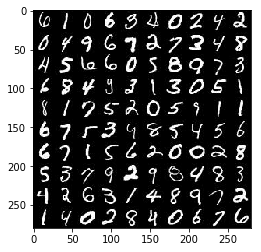

In [2]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

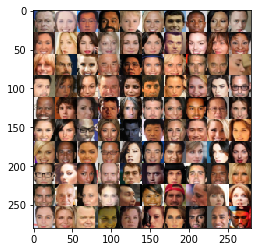

In [3]:
show_n_images = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    return (tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels)),
            tf.placeholder(dtype=tf.float32, shape=(None, z_dim)),
            tf.placeholder(dtype=tf.float32, shape=(None)))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    ## Hyperparameters
    dropout = 0.8
    layer1_outputs = 64
    layer2_outputs = 128
    layer3_outputs = 256
    out_shape = (-1, 7*7*64)
    
    def conv(inputs, num_outputs, kernel_size=5, stride=2, padding='same'):
        return tf.layers.conv2d(inputs, 
                                num_outputs, 
                                kernel_size, 
                                strides=stride,
                                padding=padding,
                                activation=tf.nn.elu, 
                                kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=1.0, 
                                                                                                  mode='FAN_IN', 
                                                                                                  uniform=True))
    
    with tf.variable_scope('discriminator', reuse=reuse):
        ## Layer 1; input: 28x28x3; output:
        conv1 = conv(images, layer1_outputs)
        
        ## Layer 2
        conv2 = conv(conv1, layer2_outputs)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.nn.dropout(conv2, keep_prob=dropout)
        
        ## Layer 3
        conv3 = conv(conv2, layer3_outputs)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.nn.dropout(conv3, keep_prob=dropout)
        
        flat = tf.reshape(conv3, (-1,  4 * 4 * layer3_outputs))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return (output, logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
# Initialization: He (https://www.tensorflow.org/api_docs/python/tf/contrib/layers/variance_scaling_initializer)
# Activation: Exponential Linear Unit (ELU)
# Regularization: Dropout
# Optimizer: Nadam (https://www.tensorflow.org/api_docs/python/tf/contrib/opt/NadamOptimizer)

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    ## Hyperparameters
    dropout = 0.8
    inputs = 7*7*512
    layer1_outputs = 256
    layer2_outputs = 128
    layer3_outputs = 64
    
    shape = 28 * 28 * out_channel_dim
    def conv_transpose(inputs, filters, kernel_size=5, strides=2, padding='same'):
        return tf.layers.conv2d_transpose(inputs, 
                                          filters, 
                                          kernel_size, 
                                          strides=strides,
                                          padding=padding,
                                          activation=tf.nn.elu,
                                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(factor=1.0, 
                                                                                                            mode='FAN_IN', 
                                                                                                            uniform=True))
    
    with tf.variable_scope('generator', reuse=not is_train):
        ## Layer 0
        dense1 = tf.layers.dense(z, 7*7*512)
        dense1 = tf.reshape(dense1, (-1, 7, 7, 512))
        dense1 = tf.layers.batch_normalization(dense1, training=is_train)
        dense1 = tf.nn.dropout(dense1, keep_prob=dropout)
        
        ## Layer 1
        conv1 = conv_transpose(dense1, layer1_outputs, strides=1)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.nn.dropout(conv1, keep_prob=dropout)

        ## Layer 2
        conv2 = conv_transpose(conv1, layer2_outputs)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.nn.dropout(conv2, keep_prob=dropout)
    
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    def loss(logits, labels):
        # Use cross entropy
        # Smooth labels by multiplying them by 0.9
        return tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels*.9))
    
    gen = generator(input_z, out_channel_dim)
    dis_real_out, dis_real_logits = discriminator(input_real) # Expected
    dis_not_real_out, dis_not_real_logits = discriminator(gen, reuse=True)
    
    dis_real_loss = loss(dis_real_logits, tf.ones_like(dis_real_out))
    dis_not_real_loss = loss(dis_not_real_logits, tf.zeros_like(dis_not_real_out))
    
    dis_total_loss = dis_real_loss + dis_not_real_loss
    gen_loss = loss(dis_not_real_logits, tf.ones_like(dis_not_real_out))
    return dis_total_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    def op(loss, var_list, learning_rate=learning_rate, beta1=beta1):
        # Use NAdam
        return tf.contrib.opt.NadamOptimizer(learning_rate=learning_rate, 
                                             beta1=beta1).minimize(loss, 
                                                                   var_list=var_list)

    trainables = tf.trainable_variables() # Collect tf vars created with trainable=True
    dis_vars = [t for t in trainables if 'discriminator' in t.name] # Collect vars containing 'discriminator'
    gen_vars = [t for t in trainables if 'generator' in t.name] # Collect vars containing 'generator'
    
    # Update graph operations
    ctrl_inputs = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # https://stackoverflow.com/questions/48260394/whats-the-differences-between-tf-graphkeys-trainable-variables-and-tf-graphkeys
    with tf.control_dependencies(ctrl_inputs):
        dis_train = op(d_loss, var_list=dis_vars)
        gen_train = op(g_loss, var_list=gen_vars)
    
    return dis_train, gen_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # (tensor of real input images, tensor of z data, learning rate)
    in_imgs, z_data, learning_rate_ = model_inputs(data_shape[1], 
                                                   data_shape[2], 
                                                   data_shape[3],
                                                   z_dim) 
    
    # (discriminator loss, generator loss)
    dis_loss, gen_loss = model_loss(in_imgs, 
                                    z_data, 
                                    data_shape[3]) 
    # (discriminator training operation, generator training operation)
    dis_train_op, gen_train_op = model_opt(dis_loss, 
                                           gen_loss, 
                                           learning_rate, 
                                           beta1) 
    cur_batch = 0 # Track the current batch for consisten output
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):               
                batch_images *= 2. # For some reason batch_images data is half what it should be??
                
                # batch_size x z_dim array filled with random float32 in [-1,1]
                batch_ = tf.random_uniform((batch_size, z_dim), minval=-1, maxval=1).eval()
                
                # Use feed_dict accross operations;
                feed_dict = {in_imgs: batch_images, 
                             z_data: batch_, 
                             learning_rate_: learning_rate}
                
                # Run discriminator model
                sess.run(dis_train_op, 
                         feed_dict=feed_dict)
                
                # Run generator model
                sess.run(gen_train_op, 
                         feed_dict=feed_dict)
                
                    
                if cur_batch % 5 == 0:
                    ## Show loss every five batches
                    dis_train_loss = dis_loss.eval(feed_dict)
                    gen_train_loss = gen_loss.eval(feed_dict)
                    print("Epoch {}/{}".format(epoch_i+1, epochs),
                          "Batch {}".format(cur_batch),
                          "Discriminator Loss: {:.4f}".format(dis_train_loss),
                          "Generator Loss: {:.4f}".format(gen_train_loss))
                if cur_batch % 50 == 0:
                    # Show generator output every hundred batches
                    show_generator_output(sess, 20, z_data, data_shape[3], data_image_mode)
                    
                cur_batch += 1 # Update cur_batch 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/3 Batch 0 Discriminator Loss: 6.0923 Generator Loss: 0.6906


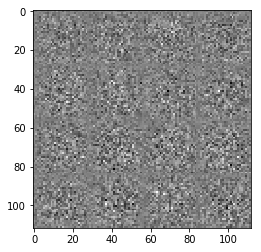

Epoch 1/3 Batch 5 Discriminator Loss: 3.5289 Generator Loss: 0.5952
Epoch 1/3 Batch 10 Discriminator Loss: 2.9240 Generator Loss: 0.4983
Epoch 1/3 Batch 15 Discriminator Loss: 2.5301 Generator Loss: 0.6822
Epoch 1/3 Batch 20 Discriminator Loss: 1.4244 Generator Loss: 0.7450
Epoch 1/3 Batch 25 Discriminator Loss: 1.9245 Generator Loss: 0.8775
Epoch 1/3 Batch 30 Discriminator Loss: 0.9614 Generator Loss: 1.8529
Epoch 1/3 Batch 35 Discriminator Loss: 0.6814 Generator Loss: 1.7813
Epoch 1/3 Batch 40 Discriminator Loss: 0.5152 Generator Loss: 2.1310
Epoch 1/3 Batch 45 Discriminator Loss: 0.9911 Generator Loss: 1.9936
Epoch 1/3 Batch 50 Discriminator Loss: 1.7921 Generator Loss: 1.1881


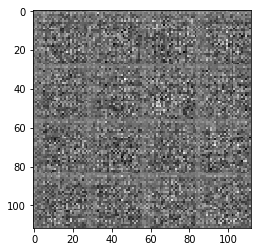

Epoch 1/3 Batch 55 Discriminator Loss: 0.6515 Generator Loss: 2.5767
Epoch 1/3 Batch 60 Discriminator Loss: 0.5443 Generator Loss: 2.4336
Epoch 1/3 Batch 65 Discriminator Loss: 0.4892 Generator Loss: 2.6503
Epoch 1/3 Batch 70 Discriminator Loss: 0.7107 Generator Loss: 2.8528
Epoch 1/3 Batch 75 Discriminator Loss: 0.6513 Generator Loss: 2.4183
Epoch 1/3 Batch 80 Discriminator Loss: 0.5036 Generator Loss: 2.6711
Epoch 1/3 Batch 85 Discriminator Loss: 0.5455 Generator Loss: 2.8720
Epoch 1/3 Batch 90 Discriminator Loss: 1.8137 Generator Loss: 1.2991
Epoch 1/3 Batch 95 Discriminator Loss: 0.5733 Generator Loss: 2.5002
Epoch 1/3 Batch 100 Discriminator Loss: 0.8111 Generator Loss: 1.9840


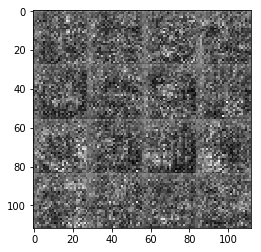

Epoch 1/3 Batch 105 Discriminator Loss: 2.0099 Generator Loss: 1.1359
Epoch 1/3 Batch 110 Discriminator Loss: 0.5119 Generator Loss: 3.2597
Epoch 1/3 Batch 115 Discriminator Loss: 0.9422 Generator Loss: 1.5336
Epoch 1/3 Batch 120 Discriminator Loss: 1.0985 Generator Loss: 1.2890
Epoch 1/3 Batch 125 Discriminator Loss: 1.0352 Generator Loss: 4.1504
Epoch 1/3 Batch 130 Discriminator Loss: 1.0038 Generator Loss: 2.2387
Epoch 1/3 Batch 135 Discriminator Loss: 6.0670 Generator Loss: 0.5494
Epoch 1/3 Batch 140 Discriminator Loss: 2.5563 Generator Loss: 0.5805
Epoch 1/3 Batch 145 Discriminator Loss: 1.7606 Generator Loss: 3.5917
Epoch 1/3 Batch 150 Discriminator Loss: 3.8414 Generator Loss: 0.4493


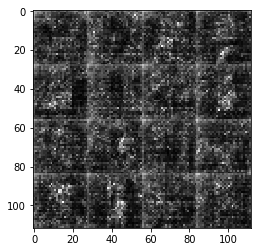

Epoch 1/3 Batch 155 Discriminator Loss: 2.1777 Generator Loss: 2.2026
Epoch 1/3 Batch 160 Discriminator Loss: 2.7621 Generator Loss: 0.3998
Epoch 1/3 Batch 165 Discriminator Loss: 1.8077 Generator Loss: 1.5699
Epoch 1/3 Batch 170 Discriminator Loss: 2.4535 Generator Loss: 0.4197
Epoch 1/3 Batch 175 Discriminator Loss: 2.3861 Generator Loss: 2.2992
Epoch 1/3 Batch 180 Discriminator Loss: 1.8056 Generator Loss: 0.5270
Epoch 1/3 Batch 185 Discriminator Loss: 2.2559 Generator Loss: 2.4973
Epoch 1/3 Batch 190 Discriminator Loss: 1.6141 Generator Loss: 0.4871
Epoch 1/3 Batch 195 Discriminator Loss: 1.5776 Generator Loss: 1.7567
Epoch 1/3 Batch 200 Discriminator Loss: 1.7969 Generator Loss: 0.5253


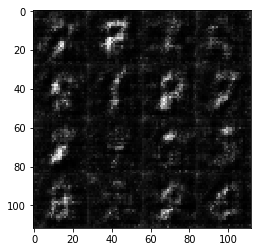

Epoch 1/3 Batch 205 Discriminator Loss: 1.5360 Generator Loss: 2.0395
Epoch 1/3 Batch 210 Discriminator Loss: 1.7287 Generator Loss: 0.5329
Epoch 1/3 Batch 215 Discriminator Loss: 1.5830 Generator Loss: 1.3330
Epoch 1/3 Batch 220 Discriminator Loss: 1.5611 Generator Loss: 0.6328
Epoch 1/3 Batch 225 Discriminator Loss: 1.4363 Generator Loss: 1.7547
Epoch 1/3 Batch 230 Discriminator Loss: 1.2490 Generator Loss: 0.6995
Epoch 1/3 Batch 235 Discriminator Loss: 1.3937 Generator Loss: 1.4797
Epoch 1/3 Batch 240 Discriminator Loss: 1.5757 Generator Loss: 0.5218
Epoch 1/3 Batch 245 Discriminator Loss: 1.4909 Generator Loss: 1.7646
Epoch 1/3 Batch 250 Discriminator Loss: 1.1680 Generator Loss: 0.7372


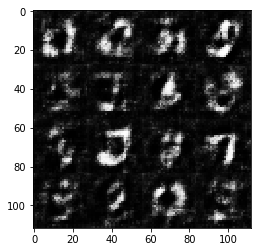

Epoch 1/3 Batch 255 Discriminator Loss: 1.9055 Generator Loss: 0.4402
Epoch 1/3 Batch 260 Discriminator Loss: 1.0816 Generator Loss: 1.1883
Epoch 1/3 Batch 265 Discriminator Loss: 1.3515 Generator Loss: 0.6016
Epoch 1/3 Batch 270 Discriminator Loss: 1.3922 Generator Loss: 1.6552
Epoch 1/3 Batch 275 Discriminator Loss: 1.5261 Generator Loss: 0.6842
Epoch 1/3 Batch 280 Discriminator Loss: 1.6024 Generator Loss: 2.4052
Epoch 1/3 Batch 285 Discriminator Loss: 1.3745 Generator Loss: 0.6728
Epoch 1/3 Batch 290 Discriminator Loss: 1.4391 Generator Loss: 1.3825
Epoch 1/3 Batch 295 Discriminator Loss: 1.7321 Generator Loss: 0.5610
Epoch 1/3 Batch 300 Discriminator Loss: 1.4297 Generator Loss: 1.5324


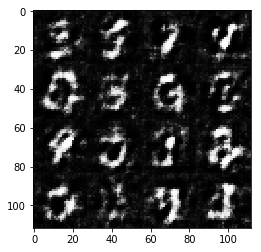

Epoch 1/3 Batch 305 Discriminator Loss: 1.2287 Generator Loss: 0.7344
Epoch 1/3 Batch 310 Discriminator Loss: 1.3344 Generator Loss: 1.9261
Epoch 1/3 Batch 315 Discriminator Loss: 1.5954 Generator Loss: 0.4907
Epoch 1/3 Batch 320 Discriminator Loss: 1.2435 Generator Loss: 1.4721
Epoch 1/3 Batch 325 Discriminator Loss: 1.1289 Generator Loss: 0.8709
Epoch 1/3 Batch 330 Discriminator Loss: 1.0573 Generator Loss: 1.5645
Epoch 1/3 Batch 335 Discriminator Loss: 1.5736 Generator Loss: 0.5332
Epoch 1/3 Batch 340 Discriminator Loss: 1.2668 Generator Loss: 1.7135
Epoch 1/3 Batch 345 Discriminator Loss: 1.2647 Generator Loss: 0.7780
Epoch 1/3 Batch 350 Discriminator Loss: 1.2720 Generator Loss: 1.8528


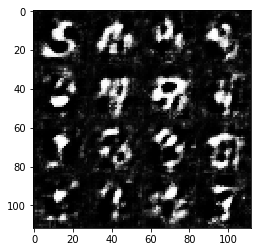

Epoch 1/3 Batch 355 Discriminator Loss: 1.1319 Generator Loss: 1.1352
Epoch 1/3 Batch 360 Discriminator Loss: 1.0784 Generator Loss: 1.1848
Epoch 1/3 Batch 365 Discriminator Loss: 1.6026 Generator Loss: 0.5917
Epoch 1/3 Batch 370 Discriminator Loss: 1.6292 Generator Loss: 2.3168
Epoch 1/3 Batch 375 Discriminator Loss: 1.5041 Generator Loss: 0.5624
Epoch 1/3 Batch 380 Discriminator Loss: 1.2923 Generator Loss: 0.7830
Epoch 1/3 Batch 385 Discriminator Loss: 1.2477 Generator Loss: 1.4359
Epoch 1/3 Batch 390 Discriminator Loss: 1.5808 Generator Loss: 0.6113
Epoch 1/3 Batch 395 Discriminator Loss: 1.1562 Generator Loss: 0.9412
Epoch 1/3 Batch 400 Discriminator Loss: 1.0541 Generator Loss: 1.1867


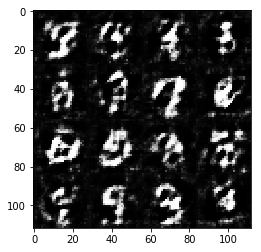

Epoch 1/3 Batch 405 Discriminator Loss: 1.2129 Generator Loss: 0.9131
Epoch 1/3 Batch 410 Discriminator Loss: 1.3223 Generator Loss: 1.6242
Epoch 1/3 Batch 415 Discriminator Loss: 1.1595 Generator Loss: 0.8303
Epoch 1/3 Batch 420 Discriminator Loss: 1.5533 Generator Loss: 0.5138
Epoch 1/3 Batch 425 Discriminator Loss: 1.1275 Generator Loss: 1.4703
Epoch 1/3 Batch 430 Discriminator Loss: 1.1787 Generator Loss: 0.8105
Epoch 1/3 Batch 435 Discriminator Loss: 1.5030 Generator Loss: 1.7456
Epoch 1/3 Batch 440 Discriminator Loss: 1.4215 Generator Loss: 0.6270
Epoch 1/3 Batch 445 Discriminator Loss: 1.2088 Generator Loss: 1.1201
Epoch 1/3 Batch 450 Discriminator Loss: 1.0186 Generator Loss: 1.0241


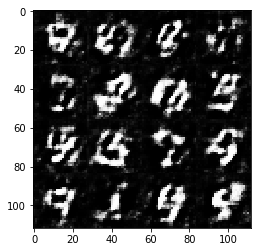

Epoch 1/3 Batch 455 Discriminator Loss: 1.1006 Generator Loss: 1.4064
Epoch 1/3 Batch 460 Discriminator Loss: 1.5714 Generator Loss: 0.5189
Epoch 1/3 Batch 465 Discriminator Loss: 1.0878 Generator Loss: 1.6662
Epoch 1/3 Batch 470 Discriminator Loss: 1.1527 Generator Loss: 1.2260
Epoch 1/3 Batch 475 Discriminator Loss: 1.6117 Generator Loss: 0.6273
Epoch 1/3 Batch 480 Discriminator Loss: 1.2992 Generator Loss: 1.3041
Epoch 1/3 Batch 485 Discriminator Loss: 1.2485 Generator Loss: 0.8478
Epoch 1/3 Batch 490 Discriminator Loss: 1.2649 Generator Loss: 0.9894
Epoch 1/3 Batch 495 Discriminator Loss: 1.4322 Generator Loss: 0.5954
Epoch 1/3 Batch 500 Discriminator Loss: 1.0360 Generator Loss: 1.2850


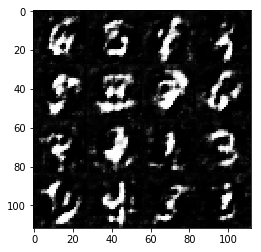

Epoch 1/3 Batch 505 Discriminator Loss: 1.4324 Generator Loss: 0.5292
Epoch 1/3 Batch 510 Discriminator Loss: 1.3087 Generator Loss: 0.9736
Epoch 1/3 Batch 515 Discriminator Loss: 1.1165 Generator Loss: 0.9556
Epoch 1/3 Batch 520 Discriminator Loss: 1.1146 Generator Loss: 0.9691
Epoch 1/3 Batch 525 Discriminator Loss: 1.4946 Generator Loss: 0.6021
Epoch 1/3 Batch 530 Discriminator Loss: 1.1984 Generator Loss: 1.6021
Epoch 1/3 Batch 535 Discriminator Loss: 1.3701 Generator Loss: 0.6532
Epoch 1/3 Batch 540 Discriminator Loss: 0.9100 Generator Loss: 1.3823
Epoch 1/3 Batch 545 Discriminator Loss: 1.0319 Generator Loss: 1.2029
Epoch 1/3 Batch 550 Discriminator Loss: 0.9523 Generator Loss: 0.9279


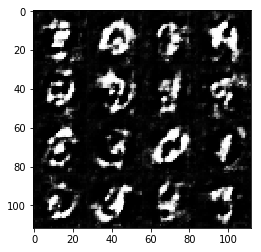

Epoch 1/3 Batch 555 Discriminator Loss: 1.3377 Generator Loss: 0.5890
Epoch 1/3 Batch 560 Discriminator Loss: 1.0506 Generator Loss: 1.4102
Epoch 1/3 Batch 565 Discriminator Loss: 1.0440 Generator Loss: 1.0033
Epoch 1/3 Batch 570 Discriminator Loss: 1.0203 Generator Loss: 1.3524
Epoch 1/3 Batch 575 Discriminator Loss: 1.5032 Generator Loss: 0.5375
Epoch 1/3 Batch 580 Discriminator Loss: 1.1769 Generator Loss: 1.3931
Epoch 1/3 Batch 585 Discriminator Loss: 1.7133 Generator Loss: 0.5648
Epoch 1/3 Batch 590 Discriminator Loss: 1.0569 Generator Loss: 1.3201
Epoch 1/3 Batch 595 Discriminator Loss: 1.1609 Generator Loss: 0.7214
Epoch 1/3 Batch 600 Discriminator Loss: 0.9237 Generator Loss: 1.2875


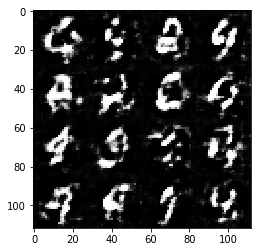

Epoch 1/3 Batch 605 Discriminator Loss: 1.2080 Generator Loss: 0.6803
Epoch 1/3 Batch 610 Discriminator Loss: 0.9985 Generator Loss: 1.7478
Epoch 1/3 Batch 615 Discriminator Loss: 2.0188 Generator Loss: 0.4235
Epoch 1/3 Batch 620 Discriminator Loss: 1.2078 Generator Loss: 1.8696
Epoch 1/3 Batch 625 Discriminator Loss: 1.2980 Generator Loss: 0.7107
Epoch 1/3 Batch 630 Discriminator Loss: 1.2331 Generator Loss: 0.6064
Epoch 1/3 Batch 635 Discriminator Loss: 1.0701 Generator Loss: 1.2939
Epoch 1/3 Batch 640 Discriminator Loss: 1.5040 Generator Loss: 0.5591
Epoch 1/3 Batch 645 Discriminator Loss: 1.0742 Generator Loss: 1.4969
Epoch 1/3 Batch 650 Discriminator Loss: 1.4504 Generator Loss: 0.5619


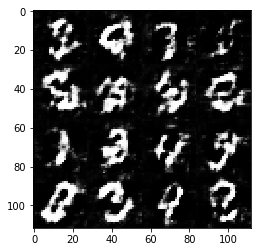

Epoch 1/3 Batch 655 Discriminator Loss: 1.1934 Generator Loss: 1.5949
Epoch 1/3 Batch 660 Discriminator Loss: 1.0288 Generator Loss: 1.2647
Epoch 1/3 Batch 665 Discriminator Loss: 0.9855 Generator Loss: 1.3194
Epoch 1/3 Batch 670 Discriminator Loss: 1.1736 Generator Loss: 1.1586
Epoch 1/3 Batch 675 Discriminator Loss: 1.9439 Generator Loss: 0.4343
Epoch 1/3 Batch 680 Discriminator Loss: 1.2630 Generator Loss: 2.0296
Epoch 1/3 Batch 685 Discriminator Loss: 1.2850 Generator Loss: 0.9203
Epoch 1/3 Batch 690 Discriminator Loss: 1.6024 Generator Loss: 0.6516
Epoch 1/3 Batch 695 Discriminator Loss: 1.4563 Generator Loss: 1.6960
Epoch 1/3 Batch 700 Discriminator Loss: 1.3731 Generator Loss: 0.6706


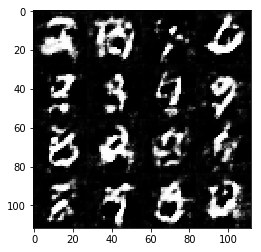

Epoch 1/3 Batch 705 Discriminator Loss: 1.1615 Generator Loss: 1.4685
Epoch 1/3 Batch 710 Discriminator Loss: 1.1034 Generator Loss: 1.0578
Epoch 1/3 Batch 715 Discriminator Loss: 1.2789 Generator Loss: 1.0748
Epoch 1/3 Batch 720 Discriminator Loss: 1.5152 Generator Loss: 0.6534
Epoch 1/3 Batch 725 Discriminator Loss: 1.1114 Generator Loss: 1.0470
Epoch 1/3 Batch 730 Discriminator Loss: 1.4541 Generator Loss: 0.5652
Epoch 1/3 Batch 735 Discriminator Loss: 1.2025 Generator Loss: 1.6287
Epoch 1/3 Batch 740 Discriminator Loss: 1.7217 Generator Loss: 0.5156
Epoch 1/3 Batch 745 Discriminator Loss: 1.3702 Generator Loss: 1.6201
Epoch 1/3 Batch 750 Discriminator Loss: 1.3681 Generator Loss: 0.6849


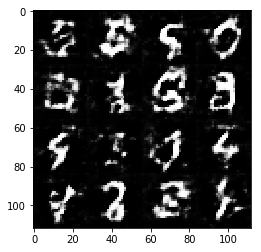

Epoch 1/3 Batch 755 Discriminator Loss: 1.2391 Generator Loss: 0.7917
Epoch 1/3 Batch 760 Discriminator Loss: 1.1703 Generator Loss: 1.5698
Epoch 1/3 Batch 765 Discriminator Loss: 1.5961 Generator Loss: 0.5974
Epoch 1/3 Batch 770 Discriminator Loss: 1.2358 Generator Loss: 0.8750
Epoch 1/3 Batch 775 Discriminator Loss: 1.3404 Generator Loss: 0.6687
Epoch 1/3 Batch 780 Discriminator Loss: 1.0538 Generator Loss: 1.2477
Epoch 1/3 Batch 785 Discriminator Loss: 1.2075 Generator Loss: 0.7385
Epoch 1/3 Batch 790 Discriminator Loss: 1.1743 Generator Loss: 1.0015
Epoch 1/3 Batch 795 Discriminator Loss: 1.2028 Generator Loss: 1.8568
Epoch 1/3 Batch 800 Discriminator Loss: 1.4648 Generator Loss: 0.6473


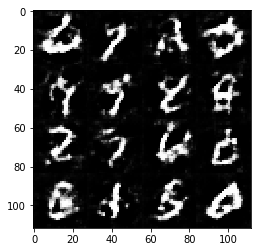

Epoch 1/3 Batch 805 Discriminator Loss: 1.2137 Generator Loss: 0.7994
Epoch 1/3 Batch 810 Discriminator Loss: 0.9744 Generator Loss: 1.2100
Epoch 1/3 Batch 815 Discriminator Loss: 1.4039 Generator Loss: 0.5950
Epoch 1/3 Batch 820 Discriminator Loss: 1.6466 Generator Loss: 1.8077
Epoch 1/3 Batch 825 Discriminator Loss: 1.1964 Generator Loss: 0.7081
Epoch 1/3 Batch 830 Discriminator Loss: 1.1156 Generator Loss: 1.5232
Epoch 1/3 Batch 835 Discriminator Loss: 1.2716 Generator Loss: 0.6531
Epoch 1/3 Batch 840 Discriminator Loss: 1.3801 Generator Loss: 1.6977
Epoch 1/3 Batch 845 Discriminator Loss: 1.2667 Generator Loss: 1.0235
Epoch 1/3 Batch 850 Discriminator Loss: 1.2520 Generator Loss: 0.5739


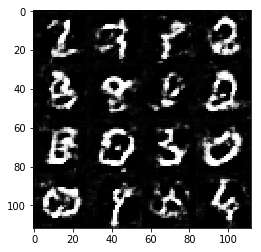

Epoch 1/3 Batch 855 Discriminator Loss: 1.3914 Generator Loss: 0.7487
Epoch 1/3 Batch 860 Discriminator Loss: 1.2210 Generator Loss: 0.9137
Epoch 1/3 Batch 865 Discriminator Loss: 1.4126 Generator Loss: 0.6230
Epoch 1/3 Batch 870 Discriminator Loss: 1.1692 Generator Loss: 1.2438
Epoch 1/3 Batch 875 Discriminator Loss: 1.1226 Generator Loss: 1.1013
Epoch 1/3 Batch 880 Discriminator Loss: 1.3138 Generator Loss: 0.8098
Epoch 1/3 Batch 885 Discriminator Loss: 1.3650 Generator Loss: 1.6395
Epoch 1/3 Batch 890 Discriminator Loss: 1.4672 Generator Loss: 0.5514
Epoch 1/3 Batch 895 Discriminator Loss: 1.1328 Generator Loss: 1.2674
Epoch 1/3 Batch 900 Discriminator Loss: 1.1609 Generator Loss: 1.1098


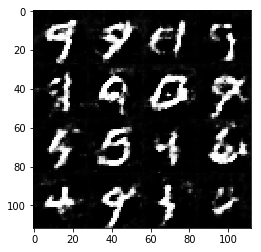

Epoch 1/3 Batch 905 Discriminator Loss: 1.0278 Generator Loss: 1.0432
Epoch 1/3 Batch 910 Discriminator Loss: 1.1221 Generator Loss: 0.9807
Epoch 1/3 Batch 915 Discriminator Loss: 1.4852 Generator Loss: 0.5914
Epoch 1/3 Batch 920 Discriminator Loss: 0.9492 Generator Loss: 1.0806
Epoch 1/3 Batch 925 Discriminator Loss: 1.2479 Generator Loss: 0.7922
Epoch 1/3 Batch 930 Discriminator Loss: 1.4298 Generator Loss: 1.9282
Epoch 1/3 Batch 935 Discriminator Loss: 1.1044 Generator Loss: 1.0466
Epoch 1/3 Batch 940 Discriminator Loss: 1.0978 Generator Loss: 1.3334
Epoch 1/3 Batch 945 Discriminator Loss: 1.3190 Generator Loss: 0.8339
Epoch 1/3 Batch 950 Discriminator Loss: 1.1743 Generator Loss: 1.0544


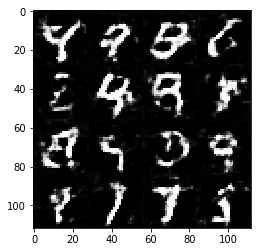

Epoch 1/3 Batch 955 Discriminator Loss: 1.3081 Generator Loss: 1.6215
Epoch 1/3 Batch 960 Discriminator Loss: 1.5372 Generator Loss: 0.6171
Epoch 1/3 Batch 965 Discriminator Loss: 1.1209 Generator Loss: 1.1241
Epoch 1/3 Batch 970 Discriminator Loss: 1.3548 Generator Loss: 0.5625
Epoch 1/3 Batch 975 Discriminator Loss: 1.5939 Generator Loss: 1.2500
Epoch 1/3 Batch 980 Discriminator Loss: 1.3596 Generator Loss: 0.7364
Epoch 1/3 Batch 985 Discriminator Loss: 1.0773 Generator Loss: 1.2573
Epoch 1/3 Batch 990 Discriminator Loss: 1.2203 Generator Loss: 0.8881
Epoch 1/3 Batch 995 Discriminator Loss: 1.0060 Generator Loss: 0.9959
Epoch 1/3 Batch 1000 Discriminator Loss: 1.2620 Generator Loss: 1.0646


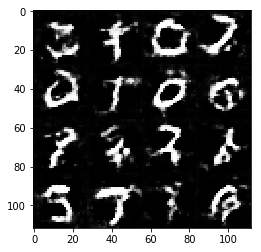

Epoch 1/3 Batch 1005 Discriminator Loss: 1.1728 Generator Loss: 0.8496
Epoch 1/3 Batch 1010 Discriminator Loss: 0.9432 Generator Loss: 1.2300
Epoch 1/3 Batch 1015 Discriminator Loss: 1.7880 Generator Loss: 0.4469
Epoch 1/3 Batch 1020 Discriminator Loss: 1.0659 Generator Loss: 1.3332
Epoch 1/3 Batch 1025 Discriminator Loss: 1.2729 Generator Loss: 1.5946
Epoch 1/3 Batch 1030 Discriminator Loss: 1.4284 Generator Loss: 0.6633
Epoch 1/3 Batch 1035 Discriminator Loss: 1.0780 Generator Loss: 1.5761
Epoch 1/3 Batch 1040 Discriminator Loss: 1.2851 Generator Loss: 0.7957
Epoch 1/3 Batch 1045 Discriminator Loss: 1.0618 Generator Loss: 0.9367
Epoch 1/3 Batch 1050 Discriminator Loss: 1.8032 Generator Loss: 0.5353


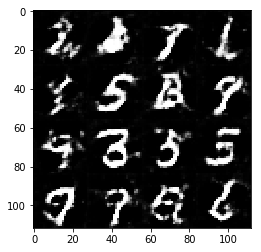

Epoch 1/3 Batch 1055 Discriminator Loss: 1.6926 Generator Loss: 1.8070
Epoch 1/3 Batch 1060 Discriminator Loss: 1.2854 Generator Loss: 0.7641
Epoch 1/3 Batch 1065 Discriminator Loss: 1.2357 Generator Loss: 0.7905
Epoch 1/3 Batch 1070 Discriminator Loss: 1.1176 Generator Loss: 0.8987
Epoch 1/3 Batch 1075 Discriminator Loss: 1.6234 Generator Loss: 1.9841
Epoch 1/3 Batch 1080 Discriminator Loss: 1.4058 Generator Loss: 1.0048
Epoch 1/3 Batch 1085 Discriminator Loss: 1.3587 Generator Loss: 0.9064
Epoch 1/3 Batch 1090 Discriminator Loss: 1.6240 Generator Loss: 0.6438
Epoch 1/3 Batch 1095 Discriminator Loss: 1.2833 Generator Loss: 0.6890
Epoch 1/3 Batch 1100 Discriminator Loss: 1.3830 Generator Loss: 1.5534


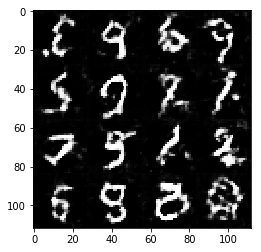

Epoch 1/3 Batch 1105 Discriminator Loss: 1.0855 Generator Loss: 0.9999
Epoch 1/3 Batch 1110 Discriminator Loss: 1.3083 Generator Loss: 0.6689
Epoch 1/3 Batch 1115 Discriminator Loss: 1.2157 Generator Loss: 1.3541
Epoch 1/3 Batch 1120 Discriminator Loss: 1.2907 Generator Loss: 0.6646
Epoch 1/3 Batch 1125 Discriminator Loss: 1.2467 Generator Loss: 1.4053
Epoch 1/3 Batch 1130 Discriminator Loss: 1.2244 Generator Loss: 0.7828
Epoch 1/3 Batch 1135 Discriminator Loss: 1.2107 Generator Loss: 0.8830
Epoch 1/3 Batch 1140 Discriminator Loss: 1.1412 Generator Loss: 0.9244
Epoch 1/3 Batch 1145 Discriminator Loss: 1.3722 Generator Loss: 0.6793
Epoch 1/3 Batch 1150 Discriminator Loss: 1.2606 Generator Loss: 1.0601


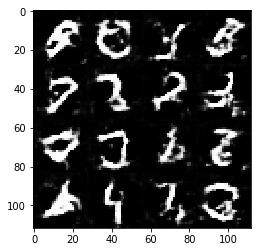

Epoch 1/3 Batch 1155 Discriminator Loss: 1.2758 Generator Loss: 0.7452
Epoch 1/3 Batch 1160 Discriminator Loss: 1.1484 Generator Loss: 1.5752
Epoch 1/3 Batch 1165 Discriminator Loss: 1.3192 Generator Loss: 0.6664
Epoch 1/3 Batch 1170 Discriminator Loss: 0.9990 Generator Loss: 1.3292
Epoch 1/3 Batch 1175 Discriminator Loss: 1.2052 Generator Loss: 0.6110
Epoch 1/3 Batch 1180 Discriminator Loss: 0.9781 Generator Loss: 1.2115
Epoch 1/3 Batch 1185 Discriminator Loss: 1.3480 Generator Loss: 0.8400
Epoch 1/3 Batch 1190 Discriminator Loss: 1.0801 Generator Loss: 0.8760
Epoch 1/3 Batch 1195 Discriminator Loss: 1.1687 Generator Loss: 0.7519
Epoch 1/3 Batch 1200 Discriminator Loss: 1.2801 Generator Loss: 1.7967


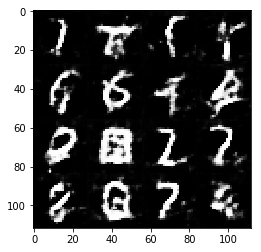

Epoch 1/3 Batch 1205 Discriminator Loss: 1.1651 Generator Loss: 1.0061
Epoch 1/3 Batch 1210 Discriminator Loss: 1.3295 Generator Loss: 0.8220
Epoch 1/3 Batch 1215 Discriminator Loss: 1.1966 Generator Loss: 0.6156
Epoch 1/3 Batch 1220 Discriminator Loss: 1.4548 Generator Loss: 0.6821
Epoch 1/3 Batch 1225 Discriminator Loss: 1.0528 Generator Loss: 1.5350
Epoch 1/3 Batch 1230 Discriminator Loss: 1.7147 Generator Loss: 0.5454
Epoch 1/3 Batch 1235 Discriminator Loss: 1.0927 Generator Loss: 0.8464
Epoch 1/3 Batch 1240 Discriminator Loss: 1.4092 Generator Loss: 0.6156
Epoch 1/3 Batch 1245 Discriminator Loss: 1.2537 Generator Loss: 0.8931
Epoch 1/3 Batch 1250 Discriminator Loss: 1.1129 Generator Loss: 1.2255


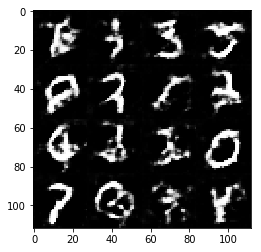

Epoch 1/3 Batch 1255 Discriminator Loss: 1.2547 Generator Loss: 0.8877
Epoch 1/3 Batch 1260 Discriminator Loss: 1.3042 Generator Loss: 0.8279
Epoch 1/3 Batch 1265 Discriminator Loss: 1.4634 Generator Loss: 0.5488
Epoch 1/3 Batch 1270 Discriminator Loss: 1.2551 Generator Loss: 1.6041
Epoch 1/3 Batch 1275 Discriminator Loss: 1.3704 Generator Loss: 0.6706
Epoch 1/3 Batch 1280 Discriminator Loss: 1.0689 Generator Loss: 0.8792
Epoch 1/3 Batch 1285 Discriminator Loss: 1.1704 Generator Loss: 0.9934
Epoch 1/3 Batch 1290 Discriminator Loss: 1.1207 Generator Loss: 1.0476
Epoch 1/3 Batch 1295 Discriminator Loss: 1.1598 Generator Loss: 1.2837
Epoch 1/3 Batch 1300 Discriminator Loss: 1.4965 Generator Loss: 0.6452


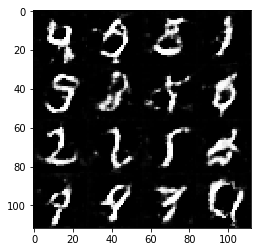

Epoch 1/3 Batch 1305 Discriminator Loss: 1.2170 Generator Loss: 0.8713
Epoch 1/3 Batch 1310 Discriminator Loss: 1.2573 Generator Loss: 1.6369
Epoch 1/3 Batch 1315 Discriminator Loss: 1.3611 Generator Loss: 0.6706
Epoch 1/3 Batch 1320 Discriminator Loss: 1.3574 Generator Loss: 1.7172
Epoch 1/3 Batch 1325 Discriminator Loss: 0.9724 Generator Loss: 1.0906
Epoch 1/3 Batch 1330 Discriminator Loss: 1.3665 Generator Loss: 1.0086
Epoch 1/3 Batch 1335 Discriminator Loss: 1.0575 Generator Loss: 1.1534
Epoch 1/3 Batch 1340 Discriminator Loss: 1.4181 Generator Loss: 0.7839
Epoch 1/3 Batch 1345 Discriminator Loss: 1.2052 Generator Loss: 1.3408
Epoch 1/3 Batch 1350 Discriminator Loss: 1.1804 Generator Loss: 1.0930


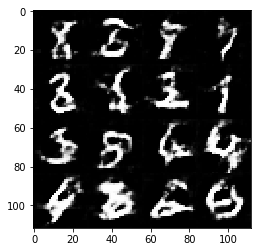

Epoch 1/3 Batch 1355 Discriminator Loss: 1.8467 Generator Loss: 0.4808
Epoch 1/3 Batch 1360 Discriminator Loss: 1.4961 Generator Loss: 1.5485
Epoch 1/3 Batch 1365 Discriminator Loss: 1.1871 Generator Loss: 0.7197
Epoch 1/3 Batch 1370 Discriminator Loss: 1.2882 Generator Loss: 1.3458
Epoch 1/3 Batch 1375 Discriminator Loss: 1.2426 Generator Loss: 0.7357
Epoch 1/3 Batch 1380 Discriminator Loss: 1.1411 Generator Loss: 1.2286
Epoch 1/3 Batch 1385 Discriminator Loss: 1.4112 Generator Loss: 0.6217
Epoch 1/3 Batch 1390 Discriminator Loss: 1.4209 Generator Loss: 0.6438
Epoch 1/3 Batch 1395 Discriminator Loss: 1.2460 Generator Loss: 1.3699
Epoch 1/3 Batch 1400 Discriminator Loss: 1.1976 Generator Loss: 0.7762


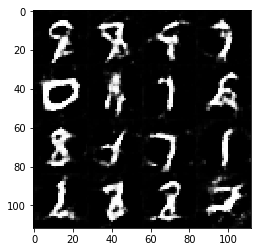

Epoch 1/3 Batch 1405 Discriminator Loss: 1.2292 Generator Loss: 0.6918
Epoch 1/3 Batch 1410 Discriminator Loss: 1.2742 Generator Loss: 1.4817
Epoch 1/3 Batch 1415 Discriminator Loss: 1.1117 Generator Loss: 0.8332
Epoch 1/3 Batch 1420 Discriminator Loss: 1.3821 Generator Loss: 0.5351
Epoch 1/3 Batch 1425 Discriminator Loss: 1.2469 Generator Loss: 1.9204
Epoch 1/3 Batch 1430 Discriminator Loss: 1.4042 Generator Loss: 0.6001
Epoch 1/3 Batch 1435 Discriminator Loss: 1.1879 Generator Loss: 0.9367
Epoch 1/3 Batch 1440 Discriminator Loss: 1.0953 Generator Loss: 1.0001
Epoch 1/3 Batch 1445 Discriminator Loss: 1.1817 Generator Loss: 0.9489
Epoch 1/3 Batch 1450 Discriminator Loss: 1.1763 Generator Loss: 1.5132


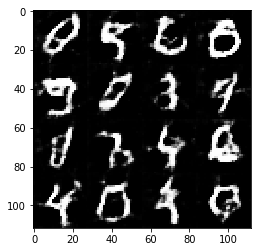

Epoch 1/3 Batch 1455 Discriminator Loss: 1.2569 Generator Loss: 0.8226
Epoch 1/3 Batch 1460 Discriminator Loss: 1.1967 Generator Loss: 1.6016
Epoch 1/3 Batch 1465 Discriminator Loss: 1.3081 Generator Loss: 0.6171
Epoch 1/3 Batch 1470 Discriminator Loss: 1.1333 Generator Loss: 1.3625
Epoch 1/3 Batch 1475 Discriminator Loss: 1.4313 Generator Loss: 0.6048
Epoch 1/3 Batch 1480 Discriminator Loss: 1.2634 Generator Loss: 1.2089
Epoch 1/3 Batch 1485 Discriminator Loss: 1.1842 Generator Loss: 0.9305
Epoch 1/3 Batch 1490 Discriminator Loss: 1.3858 Generator Loss: 1.2808
Epoch 1/3 Batch 1495 Discriminator Loss: 1.4345 Generator Loss: 0.6439
Epoch 1/3 Batch 1500 Discriminator Loss: 1.4152 Generator Loss: 1.7854


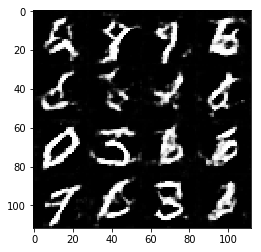

Epoch 1/3 Batch 1505 Discriminator Loss: 1.0834 Generator Loss: 1.2122
Epoch 1/3 Batch 1510 Discriminator Loss: 1.0830 Generator Loss: 1.1338
Epoch 1/3 Batch 1515 Discriminator Loss: 1.2399 Generator Loss: 0.7828
Epoch 1/3 Batch 1520 Discriminator Loss: 1.0395 Generator Loss: 1.3891
Epoch 1/3 Batch 1525 Discriminator Loss: 1.2528 Generator Loss: 0.7882
Epoch 1/3 Batch 1530 Discriminator Loss: 1.1211 Generator Loss: 1.1205
Epoch 1/3 Batch 1535 Discriminator Loss: 1.5107 Generator Loss: 0.5094
Epoch 1/3 Batch 1540 Discriminator Loss: 1.3017 Generator Loss: 1.5620
Epoch 1/3 Batch 1545 Discriminator Loss: 1.3699 Generator Loss: 0.7036
Epoch 1/3 Batch 1550 Discriminator Loss: 1.0260 Generator Loss: 1.1576


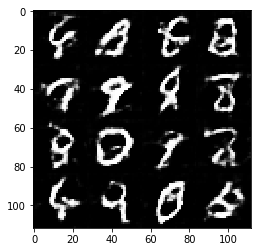

Epoch 1/3 Batch 1555 Discriminator Loss: 1.0170 Generator Loss: 1.1708
Epoch 1/3 Batch 1560 Discriminator Loss: 1.2755 Generator Loss: 0.6758
Epoch 1/3 Batch 1565 Discriminator Loss: 1.1531 Generator Loss: 0.8314
Epoch 1/3 Batch 1570 Discriminator Loss: 1.8083 Generator Loss: 1.8684
Epoch 1/3 Batch 1575 Discriminator Loss: 1.4183 Generator Loss: 0.7000
Epoch 1/3 Batch 1580 Discriminator Loss: 1.0952 Generator Loss: 0.7575
Epoch 1/3 Batch 1585 Discriminator Loss: 1.1224 Generator Loss: 1.1892
Epoch 1/3 Batch 1590 Discriminator Loss: 1.6148 Generator Loss: 0.5319
Epoch 1/3 Batch 1595 Discriminator Loss: 1.1257 Generator Loss: 0.9726
Epoch 1/3 Batch 1600 Discriminator Loss: 1.1040 Generator Loss: 1.4343


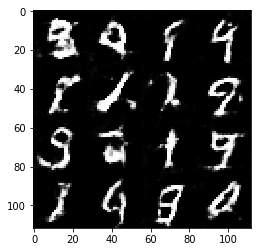

Epoch 1/3 Batch 1605 Discriminator Loss: 1.1528 Generator Loss: 0.8030
Epoch 1/3 Batch 1610 Discriminator Loss: 1.1676 Generator Loss: 1.0431
Epoch 1/3 Batch 1615 Discriminator Loss: 1.1168 Generator Loss: 0.8966
Epoch 1/3 Batch 1620 Discriminator Loss: 1.2320 Generator Loss: 1.4254
Epoch 1/3 Batch 1625 Discriminator Loss: 1.3532 Generator Loss: 0.6292
Epoch 1/3 Batch 1630 Discriminator Loss: 1.5564 Generator Loss: 0.5344
Epoch 1/3 Batch 1635 Discriminator Loss: 1.2175 Generator Loss: 1.1071
Epoch 1/3 Batch 1640 Discriminator Loss: 1.1304 Generator Loss: 0.7376
Epoch 1/3 Batch 1645 Discriminator Loss: 1.2661 Generator Loss: 0.6550
Epoch 1/3 Batch 1650 Discriminator Loss: 1.1286 Generator Loss: 1.0416


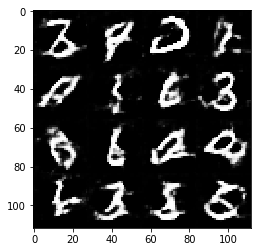

Epoch 1/3 Batch 1655 Discriminator Loss: 1.1458 Generator Loss: 1.0127
Epoch 1/3 Batch 1660 Discriminator Loss: 1.1756 Generator Loss: 0.7322
Epoch 1/3 Batch 1665 Discriminator Loss: 1.4689 Generator Loss: 0.6449
Epoch 1/3 Batch 1670 Discriminator Loss: 1.2370 Generator Loss: 1.2196
Epoch 1/3 Batch 1675 Discriminator Loss: 1.0952 Generator Loss: 1.0703
Epoch 1/3 Batch 1680 Discriminator Loss: 1.1040 Generator Loss: 0.6852
Epoch 1/3 Batch 1685 Discriminator Loss: 1.2257 Generator Loss: 1.4215
Epoch 1/3 Batch 1690 Discriminator Loss: 1.1231 Generator Loss: 1.0785
Epoch 1/3 Batch 1695 Discriminator Loss: 1.1446 Generator Loss: 0.6957
Epoch 1/3 Batch 1700 Discriminator Loss: 1.1305 Generator Loss: 1.1630


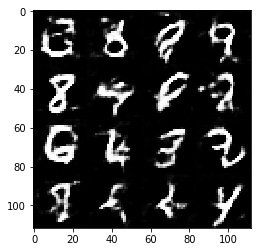

Epoch 1/3 Batch 1705 Discriminator Loss: 1.1933 Generator Loss: 0.6599
Epoch 1/3 Batch 1710 Discriminator Loss: 1.1828 Generator Loss: 0.8790
Epoch 1/3 Batch 1715 Discriminator Loss: 1.4015 Generator Loss: 2.0460
Epoch 1/3 Batch 1720 Discriminator Loss: 1.0701 Generator Loss: 0.7948
Epoch 1/3 Batch 1725 Discriminator Loss: 1.1451 Generator Loss: 1.0161
Epoch 1/3 Batch 1730 Discriminator Loss: 1.3360 Generator Loss: 0.6935
Epoch 1/3 Batch 1735 Discriminator Loss: 1.2285 Generator Loss: 1.3796
Epoch 1/3 Batch 1740 Discriminator Loss: 1.2912 Generator Loss: 0.6584
Epoch 1/3 Batch 1745 Discriminator Loss: 0.9247 Generator Loss: 1.4601
Epoch 1/3 Batch 1750 Discriminator Loss: 1.3762 Generator Loss: 0.6811


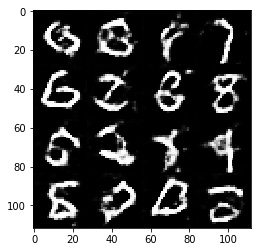

Epoch 1/3 Batch 1755 Discriminator Loss: 1.0692 Generator Loss: 1.6614
Epoch 1/3 Batch 1760 Discriminator Loss: 1.0970 Generator Loss: 0.7303
Epoch 1/3 Batch 1765 Discriminator Loss: 1.0425 Generator Loss: 1.4271
Epoch 1/3 Batch 1770 Discriminator Loss: 1.1704 Generator Loss: 1.4681
Epoch 1/3 Batch 1775 Discriminator Loss: 1.4419 Generator Loss: 0.6533
Epoch 1/3 Batch 1780 Discriminator Loss: 1.0457 Generator Loss: 1.1804
Epoch 1/3 Batch 1785 Discriminator Loss: 1.1430 Generator Loss: 0.8194
Epoch 1/3 Batch 1790 Discriminator Loss: 1.1065 Generator Loss: 0.9644
Epoch 1/3 Batch 1795 Discriminator Loss: 1.2800 Generator Loss: 0.7492
Epoch 1/3 Batch 1800 Discriminator Loss: 1.1873 Generator Loss: 0.7984


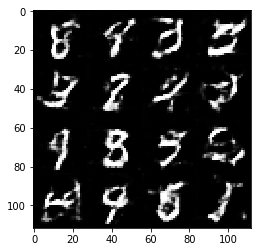

Epoch 1/3 Batch 1805 Discriminator Loss: 1.3888 Generator Loss: 1.7078
Epoch 1/3 Batch 1810 Discriminator Loss: 1.0974 Generator Loss: 0.8431
Epoch 1/3 Batch 1815 Discriminator Loss: 1.1561 Generator Loss: 0.9427
Epoch 1/3 Batch 1820 Discriminator Loss: 1.3712 Generator Loss: 0.6173
Epoch 1/3 Batch 1825 Discriminator Loss: 1.1609 Generator Loss: 1.1772
Epoch 1/3 Batch 1830 Discriminator Loss: 1.0564 Generator Loss: 0.7915
Epoch 1/3 Batch 1835 Discriminator Loss: 1.3888 Generator Loss: 0.5858
Epoch 1/3 Batch 1840 Discriminator Loss: 1.3003 Generator Loss: 1.1126
Epoch 1/3 Batch 1845 Discriminator Loss: 1.2698 Generator Loss: 0.7840
Epoch 1/3 Batch 1850 Discriminator Loss: 1.0584 Generator Loss: 1.2031


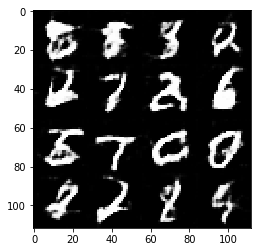

Epoch 1/3 Batch 1855 Discriminator Loss: 1.3476 Generator Loss: 0.5717
Epoch 1/3 Batch 1860 Discriminator Loss: 1.1588 Generator Loss: 0.8537
Epoch 1/3 Batch 1865 Discriminator Loss: 1.1039 Generator Loss: 1.2094
Epoch 1/3 Batch 1870 Discriminator Loss: 0.9924 Generator Loss: 1.0805
Epoch 2/3 Batch 1875 Discriminator Loss: 1.2093 Generator Loss: 1.1034
Epoch 2/3 Batch 1880 Discriminator Loss: 1.4792 Generator Loss: 0.6040
Epoch 2/3 Batch 1885 Discriminator Loss: 1.2220 Generator Loss: 1.2879
Epoch 2/3 Batch 1890 Discriminator Loss: 1.6499 Generator Loss: 0.5726
Epoch 2/3 Batch 1895 Discriminator Loss: 1.0019 Generator Loss: 1.5536
Epoch 2/3 Batch 1900 Discriminator Loss: 1.0713 Generator Loss: 1.0336


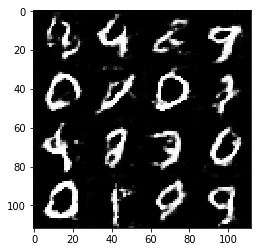

Epoch 2/3 Batch 1905 Discriminator Loss: 0.9568 Generator Loss: 1.1098
Epoch 2/3 Batch 1910 Discriminator Loss: 1.4871 Generator Loss: 0.6206
Epoch 2/3 Batch 1915 Discriminator Loss: 1.0107 Generator Loss: 1.5845
Epoch 2/3 Batch 1920 Discriminator Loss: 1.4211 Generator Loss: 0.6830
Epoch 2/3 Batch 1925 Discriminator Loss: 1.1608 Generator Loss: 0.8352
Epoch 2/3 Batch 1930 Discriminator Loss: 1.0167 Generator Loss: 1.0962
Epoch 2/3 Batch 1935 Discriminator Loss: 1.1394 Generator Loss: 1.5717
Epoch 2/3 Batch 1940 Discriminator Loss: 1.4202 Generator Loss: 0.5777
Epoch 2/3 Batch 1945 Discriminator Loss: 1.0951 Generator Loss: 0.8916
Epoch 2/3 Batch 1950 Discriminator Loss: 1.2045 Generator Loss: 1.0835


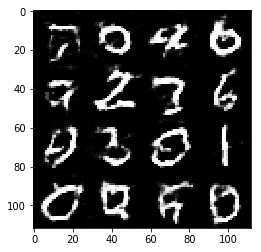

Epoch 2/3 Batch 1955 Discriminator Loss: 1.0981 Generator Loss: 1.1890
Epoch 2/3 Batch 1960 Discriminator Loss: 1.4703 Generator Loss: 0.4833
Epoch 2/3 Batch 1965 Discriminator Loss: 1.0824 Generator Loss: 0.9031
Epoch 2/3 Batch 1970 Discriminator Loss: 1.0499 Generator Loss: 0.8907
Epoch 2/3 Batch 1975 Discriminator Loss: 1.2278 Generator Loss: 0.7184
Epoch 2/3 Batch 1980 Discriminator Loss: 1.0740 Generator Loss: 1.8542
Epoch 2/3 Batch 1985 Discriminator Loss: 1.4072 Generator Loss: 0.5871
Epoch 2/3 Batch 1990 Discriminator Loss: 1.2354 Generator Loss: 1.4600
Epoch 2/3 Batch 1995 Discriminator Loss: 1.3239 Generator Loss: 0.5669
Epoch 2/3 Batch 2000 Discriminator Loss: 1.7213 Generator Loss: 2.3114


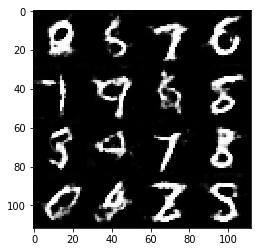

Epoch 2/3 Batch 2005 Discriminator Loss: 1.1713 Generator Loss: 1.0445
Epoch 2/3 Batch 2010 Discriminator Loss: 1.2768 Generator Loss: 0.6929
Epoch 2/3 Batch 2015 Discriminator Loss: 1.1462 Generator Loss: 1.1735
Epoch 2/3 Batch 2020 Discriminator Loss: 1.1708 Generator Loss: 0.8791
Epoch 2/3 Batch 2025 Discriminator Loss: 1.3508 Generator Loss: 1.4907
Epoch 2/3 Batch 2030 Discriminator Loss: 0.9711 Generator Loss: 0.9989
Epoch 2/3 Batch 2035 Discriminator Loss: 1.0545 Generator Loss: 1.0660
Epoch 2/3 Batch 2040 Discriminator Loss: 1.1846 Generator Loss: 0.6586
Epoch 2/3 Batch 2045 Discriminator Loss: 1.0312 Generator Loss: 1.7994
Epoch 2/3 Batch 2050 Discriminator Loss: 1.3517 Generator Loss: 0.6521


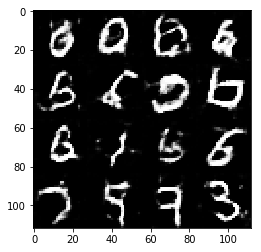

Epoch 2/3 Batch 2055 Discriminator Loss: 1.1384 Generator Loss: 1.6176
Epoch 2/3 Batch 2060 Discriminator Loss: 1.2091 Generator Loss: 0.8813
Epoch 2/3 Batch 2065 Discriminator Loss: 1.3124 Generator Loss: 1.8071
Epoch 2/3 Batch 2070 Discriminator Loss: 1.0687 Generator Loss: 1.0755
Epoch 2/3 Batch 2075 Discriminator Loss: 1.0716 Generator Loss: 0.9970
Epoch 2/3 Batch 2080 Discriminator Loss: 1.6823 Generator Loss: 0.6798
Epoch 2/3 Batch 2085 Discriminator Loss: 1.0949 Generator Loss: 0.9732
Epoch 2/3 Batch 2090 Discriminator Loss: 1.1894 Generator Loss: 0.9524
Epoch 2/3 Batch 2095 Discriminator Loss: 1.2549 Generator Loss: 0.8053
Epoch 2/3 Batch 2100 Discriminator Loss: 1.0635 Generator Loss: 1.1183


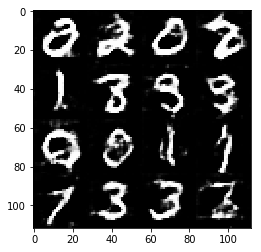

Epoch 2/3 Batch 2105 Discriminator Loss: 1.3803 Generator Loss: 0.7772
Epoch 2/3 Batch 2110 Discriminator Loss: 1.0571 Generator Loss: 1.0968
Epoch 2/3 Batch 2115 Discriminator Loss: 1.3395 Generator Loss: 0.6305
Epoch 2/3 Batch 2120 Discriminator Loss: 1.0564 Generator Loss: 0.9810
Epoch 2/3 Batch 2125 Discriminator Loss: 1.1029 Generator Loss: 1.0354
Epoch 2/3 Batch 2130 Discriminator Loss: 1.2699 Generator Loss: 0.8825
Epoch 2/3 Batch 2135 Discriminator Loss: 1.0057 Generator Loss: 1.4767
Epoch 2/3 Batch 2140 Discriminator Loss: 1.0468 Generator Loss: 0.8279
Epoch 2/3 Batch 2145 Discriminator Loss: 1.1323 Generator Loss: 0.9003
Epoch 2/3 Batch 2150 Discriminator Loss: 1.4271 Generator Loss: 2.0165


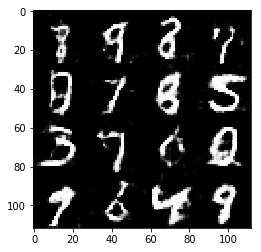

Epoch 2/3 Batch 2155 Discriminator Loss: 1.3816 Generator Loss: 0.7033
Epoch 2/3 Batch 2160 Discriminator Loss: 0.9609 Generator Loss: 1.3709
Epoch 2/3 Batch 2165 Discriminator Loss: 1.7020 Generator Loss: 0.5169
Epoch 2/3 Batch 2170 Discriminator Loss: 1.2643 Generator Loss: 1.5283
Epoch 2/3 Batch 2175 Discriminator Loss: 1.3384 Generator Loss: 0.6546
Epoch 2/3 Batch 2180 Discriminator Loss: 1.2478 Generator Loss: 0.7919
Epoch 2/3 Batch 2185 Discriminator Loss: 1.1045 Generator Loss: 1.5247
Epoch 2/3 Batch 2190 Discriminator Loss: 1.0438 Generator Loss: 1.0289
Epoch 2/3 Batch 2195 Discriminator Loss: 1.1856 Generator Loss: 0.8975
Epoch 2/3 Batch 2200 Discriminator Loss: 1.2378 Generator Loss: 1.2736


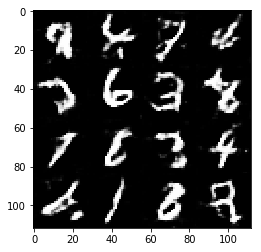

Epoch 2/3 Batch 2205 Discriminator Loss: 0.8859 Generator Loss: 1.3319
Epoch 2/3 Batch 2210 Discriminator Loss: 1.7024 Generator Loss: 0.5496
Epoch 2/3 Batch 2215 Discriminator Loss: 1.1365 Generator Loss: 1.1444
Epoch 2/3 Batch 2220 Discriminator Loss: 0.9917 Generator Loss: 0.9040
Epoch 2/3 Batch 2225 Discriminator Loss: 0.9782 Generator Loss: 1.3593
Epoch 2/3 Batch 2230 Discriminator Loss: 1.0194 Generator Loss: 1.0511
Epoch 2/3 Batch 2235 Discriminator Loss: 1.5389 Generator Loss: 0.5044
Epoch 2/3 Batch 2240 Discriminator Loss: 1.0327 Generator Loss: 1.1337
Epoch 2/3 Batch 2245 Discriminator Loss: 1.1371 Generator Loss: 1.4585
Epoch 2/3 Batch 2250 Discriminator Loss: 1.2898 Generator Loss: 0.5875


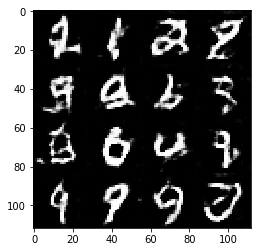

Epoch 2/3 Batch 2255 Discriminator Loss: 1.4224 Generator Loss: 0.5988
Epoch 2/3 Batch 2260 Discriminator Loss: 1.1459 Generator Loss: 1.3974
Epoch 2/3 Batch 2265 Discriminator Loss: 1.9155 Generator Loss: 0.5475
Epoch 2/3 Batch 2270 Discriminator Loss: 1.3337 Generator Loss: 0.7382
Epoch 2/3 Batch 2275 Discriminator Loss: 1.3746 Generator Loss: 0.6843
Epoch 2/3 Batch 2280 Discriminator Loss: 1.2015 Generator Loss: 1.8226
Epoch 2/3 Batch 2285 Discriminator Loss: 1.3431 Generator Loss: 0.7096
Epoch 2/3 Batch 2290 Discriminator Loss: 0.9530 Generator Loss: 1.3694
Epoch 2/3 Batch 2295 Discriminator Loss: 1.2359 Generator Loss: 0.8934
Epoch 2/3 Batch 2300 Discriminator Loss: 0.9406 Generator Loss: 1.5743


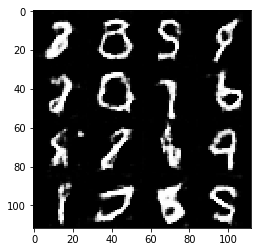

Epoch 2/3 Batch 2305 Discriminator Loss: 1.2010 Generator Loss: 1.9597
Epoch 2/3 Batch 2310 Discriminator Loss: 1.5091 Generator Loss: 0.6039
Epoch 2/3 Batch 2315 Discriminator Loss: 1.1410 Generator Loss: 1.5185
Epoch 2/3 Batch 2320 Discriminator Loss: 0.9435 Generator Loss: 1.2764
Epoch 2/3 Batch 2325 Discriminator Loss: 1.1127 Generator Loss: 0.8133
Epoch 2/3 Batch 2330 Discriminator Loss: 1.5134 Generator Loss: 2.5758
Epoch 2/3 Batch 2335 Discriminator Loss: 1.4081 Generator Loss: 0.7362
Epoch 2/3 Batch 2340 Discriminator Loss: 1.0497 Generator Loss: 1.4735
Epoch 2/3 Batch 2345 Discriminator Loss: 1.2943 Generator Loss: 0.5634
Epoch 2/3 Batch 2350 Discriminator Loss: 1.3538 Generator Loss: 1.8012


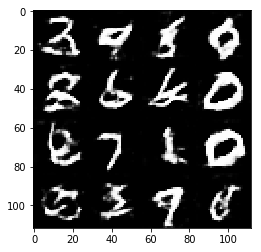

Epoch 2/3 Batch 2355 Discriminator Loss: 1.8111 Generator Loss: 0.6164
Epoch 2/3 Batch 2360 Discriminator Loss: 1.1086 Generator Loss: 1.3054
Epoch 2/3 Batch 2365 Discriminator Loss: 1.3310 Generator Loss: 0.8018
Epoch 2/3 Batch 2370 Discriminator Loss: 0.9911 Generator Loss: 1.2732
Epoch 2/3 Batch 2375 Discriminator Loss: 1.2503 Generator Loss: 0.6161
Epoch 2/3 Batch 2380 Discriminator Loss: 1.2576 Generator Loss: 1.4223
Epoch 2/3 Batch 2385 Discriminator Loss: 0.9071 Generator Loss: 1.2870
Epoch 2/3 Batch 2390 Discriminator Loss: 1.3240 Generator Loss: 0.6902
Epoch 2/3 Batch 2395 Discriminator Loss: 0.9521 Generator Loss: 1.4011
Epoch 2/3 Batch 2400 Discriminator Loss: 1.2449 Generator Loss: 0.7955


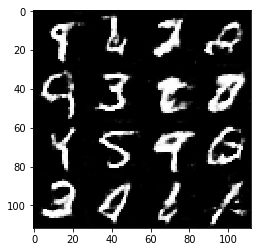

Epoch 2/3 Batch 2405 Discriminator Loss: 0.9988 Generator Loss: 1.2932
Epoch 2/3 Batch 2410 Discriminator Loss: 1.7065 Generator Loss: 0.5631
Epoch 2/3 Batch 2415 Discriminator Loss: 1.0310 Generator Loss: 1.1093
Epoch 2/3 Batch 2420 Discriminator Loss: 1.8329 Generator Loss: 2.1537
Epoch 2/3 Batch 2425 Discriminator Loss: 0.8973 Generator Loss: 1.2034
Epoch 2/3 Batch 2430 Discriminator Loss: 1.1317 Generator Loss: 0.9089
Epoch 2/3 Batch 2435 Discriminator Loss: 1.0569 Generator Loss: 1.4206
Epoch 2/3 Batch 2440 Discriminator Loss: 1.6962 Generator Loss: 0.5486
Epoch 2/3 Batch 2445 Discriminator Loss: 1.0788 Generator Loss: 1.5340
Epoch 2/3 Batch 2450 Discriminator Loss: 1.4327 Generator Loss: 0.8100


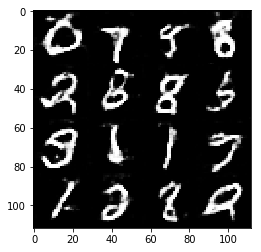

Epoch 2/3 Batch 2455 Discriminator Loss: 0.9411 Generator Loss: 1.0945
Epoch 2/3 Batch 2460 Discriminator Loss: 1.0283 Generator Loss: 1.0609
Epoch 2/3 Batch 2465 Discriminator Loss: 1.0171 Generator Loss: 0.8326
Epoch 2/3 Batch 2470 Discriminator Loss: 1.0010 Generator Loss: 1.4222
Epoch 2/3 Batch 2475 Discriminator Loss: 1.0412 Generator Loss: 0.9131
Epoch 2/3 Batch 2480 Discriminator Loss: 0.8721 Generator Loss: 0.7977
Epoch 2/3 Batch 2485 Discriminator Loss: 1.0782 Generator Loss: 0.9153
Epoch 2/3 Batch 2490 Discriminator Loss: 1.6833 Generator Loss: 0.5354
Epoch 2/3 Batch 2495 Discriminator Loss: 1.7532 Generator Loss: 2.3314
Epoch 2/3 Batch 2500 Discriminator Loss: 1.0661 Generator Loss: 1.6411


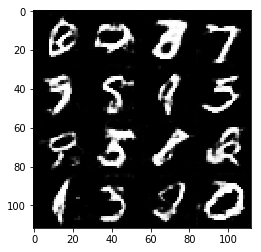

Epoch 2/3 Batch 2505 Discriminator Loss: 1.3979 Generator Loss: 0.5315
Epoch 2/3 Batch 2510 Discriminator Loss: 1.3477 Generator Loss: 0.7555
Epoch 2/3 Batch 2515 Discriminator Loss: 0.9084 Generator Loss: 0.8074
Epoch 2/3 Batch 2520 Discriminator Loss: 1.0408 Generator Loss: 0.9270
Epoch 2/3 Batch 2525 Discriminator Loss: 1.2117 Generator Loss: 1.7103
Epoch 2/3 Batch 2530 Discriminator Loss: 1.3463 Generator Loss: 0.6340
Epoch 2/3 Batch 2535 Discriminator Loss: 0.9919 Generator Loss: 1.1193
Epoch 2/3 Batch 2540 Discriminator Loss: 1.1643 Generator Loss: 0.8633
Epoch 2/3 Batch 2545 Discriminator Loss: 1.0370 Generator Loss: 0.7766
Epoch 2/3 Batch 2550 Discriminator Loss: 0.9626 Generator Loss: 0.9434


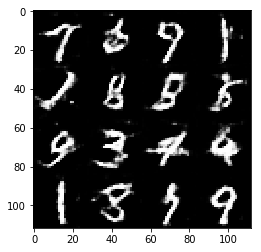

Epoch 2/3 Batch 2555 Discriminator Loss: 1.4706 Generator Loss: 0.6424
Epoch 2/3 Batch 2560 Discriminator Loss: 1.2989 Generator Loss: 1.6098
Epoch 2/3 Batch 2565 Discriminator Loss: 1.3767 Generator Loss: 0.8154
Epoch 2/3 Batch 2570 Discriminator Loss: 1.1108 Generator Loss: 1.5517
Epoch 2/3 Batch 2575 Discriminator Loss: 0.9173 Generator Loss: 0.9781
Epoch 2/3 Batch 2580 Discriminator Loss: 1.1864 Generator Loss: 1.2428
Epoch 2/3 Batch 2585 Discriminator Loss: 1.0953 Generator Loss: 0.8965
Epoch 2/3 Batch 2590 Discriminator Loss: 1.0648 Generator Loss: 1.5221
Epoch 2/3 Batch 2595 Discriminator Loss: 1.1690 Generator Loss: 0.9433
Epoch 2/3 Batch 2600 Discriminator Loss: 1.1213 Generator Loss: 1.5909


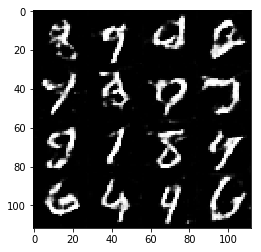

Epoch 2/3 Batch 2605 Discriminator Loss: 1.7236 Generator Loss: 0.5095
Epoch 2/3 Batch 2610 Discriminator Loss: 1.1299 Generator Loss: 0.9957
Epoch 2/3 Batch 2615 Discriminator Loss: 1.1098 Generator Loss: 1.4286
Epoch 2/3 Batch 2620 Discriminator Loss: 1.0683 Generator Loss: 0.7494
Epoch 2/3 Batch 2625 Discriminator Loss: 0.8584 Generator Loss: 1.1405
Epoch 2/3 Batch 2630 Discriminator Loss: 1.4517 Generator Loss: 0.5525
Epoch 2/3 Batch 2635 Discriminator Loss: 1.1586 Generator Loss: 0.9104
Epoch 2/3 Batch 2640 Discriminator Loss: 0.9495 Generator Loss: 1.4030
Epoch 2/3 Batch 2645 Discriminator Loss: 1.0103 Generator Loss: 1.2756
Epoch 2/3 Batch 2650 Discriminator Loss: 1.2378 Generator Loss: 0.8000


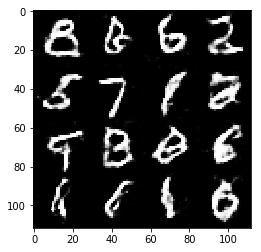

Epoch 2/3 Batch 2655 Discriminator Loss: 0.9166 Generator Loss: 1.0105
Epoch 2/3 Batch 2660 Discriminator Loss: 1.6389 Generator Loss: 0.5266
Epoch 2/3 Batch 2665 Discriminator Loss: 0.9154 Generator Loss: 1.5121
Epoch 2/3 Batch 2670 Discriminator Loss: 1.4018 Generator Loss: 0.7495
Epoch 2/3 Batch 2675 Discriminator Loss: 1.0324 Generator Loss: 1.3612
Epoch 2/3 Batch 2680 Discriminator Loss: 0.9777 Generator Loss: 1.0877
Epoch 2/3 Batch 2685 Discriminator Loss: 1.2081 Generator Loss: 0.6943
Epoch 2/3 Batch 2690 Discriminator Loss: 0.9428 Generator Loss: 1.2975
Epoch 2/3 Batch 2695 Discriminator Loss: 1.6003 Generator Loss: 0.5417
Epoch 2/3 Batch 2700 Discriminator Loss: 1.1795 Generator Loss: 1.5607


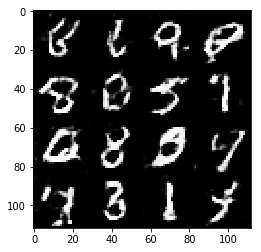

Epoch 2/3 Batch 2705 Discriminator Loss: 0.9425 Generator Loss: 1.2591
Epoch 2/3 Batch 2710 Discriminator Loss: 1.8843 Generator Loss: 0.6185
Epoch 2/3 Batch 2715 Discriminator Loss: 0.9811 Generator Loss: 1.5956
Epoch 2/3 Batch 2720 Discriminator Loss: 1.0534 Generator Loss: 0.9406
Epoch 2/3 Batch 2725 Discriminator Loss: 1.1145 Generator Loss: 1.7161
Epoch 2/3 Batch 2730 Discriminator Loss: 1.3914 Generator Loss: 0.6951
Epoch 2/3 Batch 2735 Discriminator Loss: 1.2347 Generator Loss: 0.5521
Epoch 2/3 Batch 2740 Discriminator Loss: 1.0359 Generator Loss: 1.2526
Epoch 2/3 Batch 2745 Discriminator Loss: 1.3445 Generator Loss: 0.9429
Epoch 2/3 Batch 2750 Discriminator Loss: 1.2462 Generator Loss: 0.6631


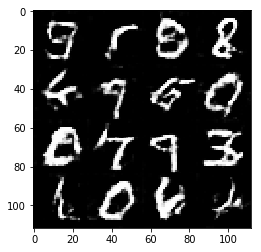

Epoch 2/3 Batch 2755 Discriminator Loss: 1.2663 Generator Loss: 1.2856
Epoch 2/3 Batch 2760 Discriminator Loss: 1.5716 Generator Loss: 0.5633
Epoch 2/3 Batch 2765 Discriminator Loss: 1.1281 Generator Loss: 0.7926
Epoch 2/3 Batch 2770 Discriminator Loss: 1.1833 Generator Loss: 1.8710
Epoch 2/3 Batch 2775 Discriminator Loss: 0.9504 Generator Loss: 1.3399
Epoch 2/3 Batch 2780 Discriminator Loss: 0.9219 Generator Loss: 1.0499
Epoch 2/3 Batch 2785 Discriminator Loss: 0.9768 Generator Loss: 2.1231
Epoch 2/3 Batch 2790 Discriminator Loss: 1.5008 Generator Loss: 0.6243
Epoch 2/3 Batch 2795 Discriminator Loss: 1.0975 Generator Loss: 2.0719
Epoch 2/3 Batch 2800 Discriminator Loss: 0.9545 Generator Loss: 1.1736


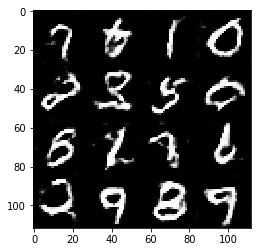

In [ ]:
batch_size = 32 # 2^5
z_dim = 128
learning_rate = 2e-4
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3 Batch 0 Discriminator Loss: 6.4928 Generator Loss: 0.7427


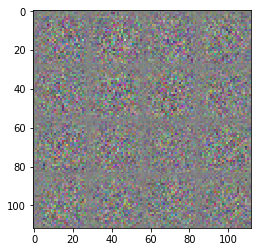

Epoch 1/3 Batch 5 Discriminator Loss: 3.5688 Generator Loss: 0.4519
Epoch 1/3 Batch 10 Discriminator Loss: 2.9035 Generator Loss: 0.5868
Epoch 1/3 Batch 15 Discriminator Loss: 2.6611 Generator Loss: 0.5713
Epoch 1/3 Batch 20 Discriminator Loss: 2.1727 Generator Loss: 0.7216
Epoch 1/3 Batch 25 Discriminator Loss: 1.4981 Generator Loss: 0.8406
Epoch 1/3 Batch 30 Discriminator Loss: 1.2500 Generator Loss: 0.8714
Epoch 1/3 Batch 35 Discriminator Loss: 0.8612 Generator Loss: 1.3873
Epoch 1/3 Batch 40 Discriminator Loss: 0.7844 Generator Loss: 1.2624
Epoch 1/3 Batch 45 Discriminator Loss: 0.6892 Generator Loss: 1.6564
Epoch 1/3 Batch 50 Discriminator Loss: 0.7610 Generator Loss: 2.1820


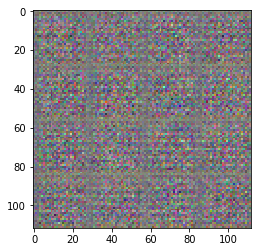

Epoch 1/3 Batch 55 Discriminator Loss: 0.8295 Generator Loss: 1.9833
Epoch 1/3 Batch 60 Discriminator Loss: 0.5144 Generator Loss: 2.4667
Epoch 1/3 Batch 65 Discriminator Loss: 1.2852 Generator Loss: 1.5154
Epoch 1/3 Batch 70 Discriminator Loss: 0.6091 Generator Loss: 2.6593
Epoch 1/3 Batch 75 Discriminator Loss: 0.4661 Generator Loss: 2.7395
Epoch 1/3 Batch 80 Discriminator Loss: 0.5091 Generator Loss: 2.8629
Epoch 1/3 Batch 85 Discriminator Loss: 0.6075 Generator Loss: 2.1920
Epoch 1/3 Batch 90 Discriminator Loss: 0.5993 Generator Loss: 2.4397
Epoch 1/3 Batch 95 Discriminator Loss: 0.4510 Generator Loss: 2.9067
Epoch 1/3 Batch 100 Discriminator Loss: 0.7272 Generator Loss: 3.3364


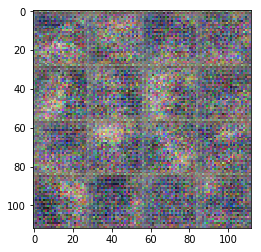

Epoch 1/3 Batch 105 Discriminator Loss: 0.7138 Generator Loss: 3.1011
Epoch 1/3 Batch 110 Discriminator Loss: 0.6916 Generator Loss: 3.1760
Epoch 1/3 Batch 115 Discriminator Loss: 0.5387 Generator Loss: 2.8998
Epoch 1/3 Batch 120 Discriminator Loss: 1.0812 Generator Loss: 3.5936
Epoch 1/3 Batch 125 Discriminator Loss: 2.3291 Generator Loss: 0.6190
Epoch 1/3 Batch 130 Discriminator Loss: 3.1770 Generator Loss: 0.7221
Epoch 1/3 Batch 135 Discriminator Loss: 0.4524 Generator Loss: 3.4226
Epoch 1/3 Batch 140 Discriminator Loss: 0.7937 Generator Loss: 3.1168
Epoch 1/3 Batch 145 Discriminator Loss: 0.6229 Generator Loss: 3.0563
Epoch 1/3 Batch 150 Discriminator Loss: 1.3556 Generator Loss: 1.1672


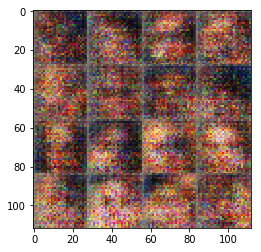

Epoch 1/3 Batch 155 Discriminator Loss: 1.4081 Generator Loss: 1.4700
Epoch 1/3 Batch 160 Discriminator Loss: 1.7918 Generator Loss: 5.6995
Epoch 1/3 Batch 165 Discriminator Loss: 1.0011 Generator Loss: 1.6500
Epoch 1/3 Batch 170 Discriminator Loss: 0.9934 Generator Loss: 1.4857
Epoch 1/3 Batch 175 Discriminator Loss: 1.1539 Generator Loss: 3.1371
Epoch 1/3 Batch 180 Discriminator Loss: 1.0690 Generator Loss: 1.0895
Epoch 1/3 Batch 185 Discriminator Loss: 1.0745 Generator Loss: 2.9323
Epoch 1/3 Batch 190 Discriminator Loss: 0.8375 Generator Loss: 3.7250
Epoch 1/3 Batch 195 Discriminator Loss: 1.6090 Generator Loss: 0.8172
Epoch 1/3 Batch 200 Discriminator Loss: 1.5444 Generator Loss: 3.8623


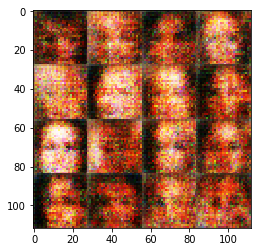

Epoch 1/3 Batch 205 Discriminator Loss: 1.7693 Generator Loss: 0.5464
Epoch 1/3 Batch 210 Discriminator Loss: 1.1024 Generator Loss: 3.6019
Epoch 1/3 Batch 215 Discriminator Loss: 1.6724 Generator Loss: 0.5397
Epoch 1/3 Batch 220 Discriminator Loss: 1.6888 Generator Loss: 4.2631
Epoch 1/3 Batch 225 Discriminator Loss: 1.1928 Generator Loss: 0.7461
Epoch 1/3 Batch 230 Discriminator Loss: 2.1260 Generator Loss: 4.7236
Epoch 1/3 Batch 235 Discriminator Loss: 0.6374 Generator Loss: 1.9249
Epoch 1/3 Batch 240 Discriminator Loss: 1.2799 Generator Loss: 3.5293
Epoch 1/3 Batch 245 Discriminator Loss: 2.6394 Generator Loss: 0.4528
Epoch 1/3 Batch 250 Discriminator Loss: 0.9459 Generator Loss: 2.9094


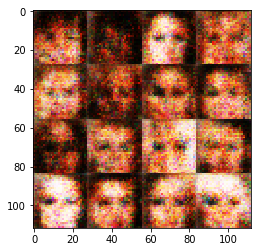

Epoch 1/3 Batch 255 Discriminator Loss: 0.6983 Generator Loss: 1.4788
Epoch 1/3 Batch 260 Discriminator Loss: 0.7127 Generator Loss: 1.5205
Epoch 1/3 Batch 265 Discriminator Loss: 1.1588 Generator Loss: 0.7906
Epoch 1/3 Batch 270 Discriminator Loss: 1.6444 Generator Loss: 2.8612
Epoch 1/3 Batch 275 Discriminator Loss: 0.9084 Generator Loss: 1.0849
Epoch 1/3 Batch 280 Discriminator Loss: 1.1150 Generator Loss: 2.8694
Epoch 1/3 Batch 285 Discriminator Loss: 1.6546 Generator Loss: 0.6838
Epoch 1/3 Batch 290 Discriminator Loss: 0.9013 Generator Loss: 2.1714
Epoch 1/3 Batch 295 Discriminator Loss: 0.9826 Generator Loss: 1.0840
Epoch 1/3 Batch 300 Discriminator Loss: 1.2944 Generator Loss: 2.8955


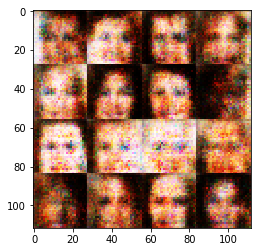

Epoch 1/3 Batch 305 Discriminator Loss: 1.6826 Generator Loss: 0.5936
Epoch 1/3 Batch 310 Discriminator Loss: 0.7873 Generator Loss: 2.3019
Epoch 1/3 Batch 315 Discriminator Loss: 1.4033 Generator Loss: 0.7513
Epoch 1/3 Batch 320 Discriminator Loss: 1.6400 Generator Loss: 3.2483
Epoch 1/3 Batch 325 Discriminator Loss: 1.3008 Generator Loss: 0.7498
Epoch 1/3 Batch 330 Discriminator Loss: 1.0843 Generator Loss: 2.1869
Epoch 1/3 Batch 335 Discriminator Loss: 1.2073 Generator Loss: 0.6856
Epoch 1/3 Batch 340 Discriminator Loss: 1.1471 Generator Loss: 2.4679
Epoch 1/3 Batch 345 Discriminator Loss: 1.2967 Generator Loss: 0.6708
Epoch 1/3 Batch 350 Discriminator Loss: 0.8879 Generator Loss: 1.9850


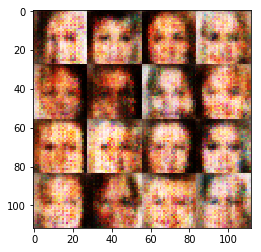

Epoch 1/3 Batch 355 Discriminator Loss: 1.5184 Generator Loss: 3.7059
Epoch 1/3 Batch 360 Discriminator Loss: 1.8829 Generator Loss: 0.5020
Epoch 1/3 Batch 365 Discriminator Loss: 0.9168 Generator Loss: 1.5319
Epoch 1/3 Batch 370 Discriminator Loss: 1.6853 Generator Loss: 0.5353
Epoch 1/3 Batch 375 Discriminator Loss: 1.1933 Generator Loss: 2.2513
Epoch 1/3 Batch 380 Discriminator Loss: 1.0347 Generator Loss: 0.9600
Epoch 1/3 Batch 385 Discriminator Loss: 1.2908 Generator Loss: 2.5643
Epoch 1/3 Batch 390 Discriminator Loss: 1.3434 Generator Loss: 0.6326
Epoch 1/3 Batch 395 Discriminator Loss: 1.5559 Generator Loss: 3.4904
Epoch 1/3 Batch 400 Discriminator Loss: 1.5790 Generator Loss: 0.6181


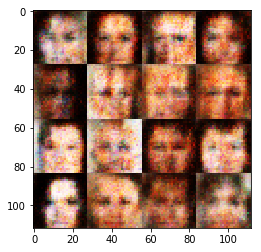

Epoch 1/3 Batch 405 Discriminator Loss: 1.0278 Generator Loss: 1.6883
Epoch 1/3 Batch 410 Discriminator Loss: 1.4906 Generator Loss: 0.7261
Epoch 1/3 Batch 415 Discriminator Loss: 1.6064 Generator Loss: 2.8022
Epoch 1/3 Batch 420 Discriminator Loss: 1.4348 Generator Loss: 0.6605
Epoch 1/3 Batch 425 Discriminator Loss: 1.2558 Generator Loss: 2.4526
Epoch 1/3 Batch 430 Discriminator Loss: 1.2053 Generator Loss: 2.0184
Epoch 1/3 Batch 435 Discriminator Loss: 1.7684 Generator Loss: 0.4995
Epoch 1/3 Batch 440 Discriminator Loss: 1.4397 Generator Loss: 1.9741
Epoch 1/3 Batch 445 Discriminator Loss: 1.7153 Generator Loss: 0.4748
Epoch 1/3 Batch 450 Discriminator Loss: 0.9623 Generator Loss: 2.0270


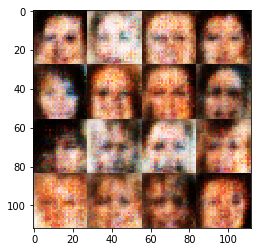

Epoch 1/3 Batch 455 Discriminator Loss: 0.8276 Generator Loss: 1.3078
Epoch 1/3 Batch 460 Discriminator Loss: 1.4870 Generator Loss: 2.5639
Epoch 1/3 Batch 465 Discriminator Loss: 1.1083 Generator Loss: 0.8271
Epoch 1/3 Batch 470 Discriminator Loss: 1.5462 Generator Loss: 3.2422
Epoch 1/3 Batch 475 Discriminator Loss: 1.4608 Generator Loss: 0.6356
Epoch 1/3 Batch 480 Discriminator Loss: 0.8922 Generator Loss: 1.4784
Epoch 1/3 Batch 485 Discriminator Loss: 1.3168 Generator Loss: 0.6775
Epoch 1/3 Batch 490 Discriminator Loss: 1.1145 Generator Loss: 1.8146
Epoch 1/3 Batch 495 Discriminator Loss: 0.9904 Generator Loss: 1.1479
Epoch 1/3 Batch 500 Discriminator Loss: 1.4825 Generator Loss: 0.6113


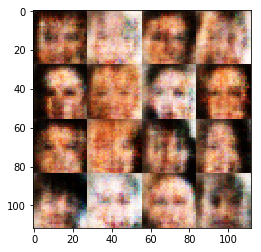

Epoch 1/3 Batch 505 Discriminator Loss: 1.5143 Generator Loss: 2.0772
Epoch 1/3 Batch 510 Discriminator Loss: 0.7534 Generator Loss: 1.7889
Epoch 1/3 Batch 515 Discriminator Loss: 1.2490 Generator Loss: 0.6764
Epoch 1/3 Batch 520 Discriminator Loss: 1.0200 Generator Loss: 2.1290
Epoch 1/3 Batch 525 Discriminator Loss: 1.2459 Generator Loss: 0.6861
Epoch 1/3 Batch 530 Discriminator Loss: 1.4645 Generator Loss: 3.0945
Epoch 1/3 Batch 535 Discriminator Loss: 1.4239 Generator Loss: 0.6243
Epoch 1/3 Batch 540 Discriminator Loss: 1.0354 Generator Loss: 1.5318
Epoch 1/3 Batch 545 Discriminator Loss: 0.9296 Generator Loss: 1.7391
Epoch 1/3 Batch 550 Discriminator Loss: 1.3513 Generator Loss: 0.7087


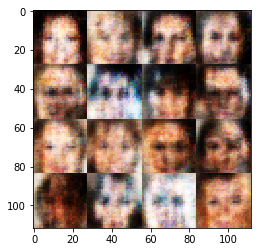

Epoch 1/3 Batch 555 Discriminator Loss: 1.4038 Generator Loss: 1.9719
Epoch 1/3 Batch 560 Discriminator Loss: 1.3898 Generator Loss: 0.7713
Epoch 1/3 Batch 565 Discriminator Loss: 1.2285 Generator Loss: 1.9718
Epoch 1/3 Batch 570 Discriminator Loss: 1.5206 Generator Loss: 0.5808
Epoch 1/3 Batch 575 Discriminator Loss: 0.8017 Generator Loss: 2.4151
Epoch 1/3 Batch 580 Discriminator Loss: 1.7100 Generator Loss: 0.5218
Epoch 1/3 Batch 585 Discriminator Loss: 0.9814 Generator Loss: 1.2150
Epoch 1/3 Batch 590 Discriminator Loss: 1.0516 Generator Loss: 0.7897
Epoch 1/3 Batch 595 Discriminator Loss: 1.5116 Generator Loss: 1.5481
Epoch 1/3 Batch 600 Discriminator Loss: 0.9282 Generator Loss: 2.2279


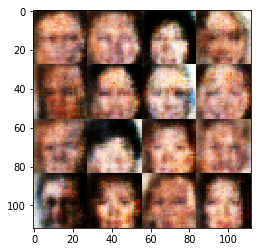

Epoch 1/3 Batch 605 Discriminator Loss: 1.4176 Generator Loss: 0.6698
Epoch 1/3 Batch 610 Discriminator Loss: 1.0673 Generator Loss: 1.7251
Epoch 1/3 Batch 615 Discriminator Loss: 1.2304 Generator Loss: 0.9075
Epoch 1/3 Batch 620 Discriminator Loss: 1.3897 Generator Loss: 1.9870
Epoch 1/3 Batch 625 Discriminator Loss: 1.2300 Generator Loss: 0.8481
Epoch 1/3 Batch 630 Discriminator Loss: 0.9957 Generator Loss: 1.5729
Epoch 1/3 Batch 635 Discriminator Loss: 1.7336 Generator Loss: 0.5233
Epoch 1/3 Batch 640 Discriminator Loss: 0.9615 Generator Loss: 0.9921
Epoch 1/3 Batch 645 Discriminator Loss: 1.6178 Generator Loss: 1.9451
Epoch 1/3 Batch 650 Discriminator Loss: 0.9778 Generator Loss: 1.1289


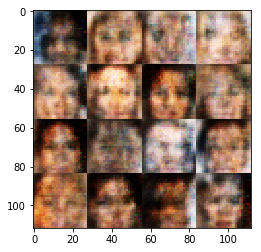

Epoch 1/3 Batch 655 Discriminator Loss: 1.3984 Generator Loss: 0.5682
Epoch 1/3 Batch 660 Discriminator Loss: 1.4938 Generator Loss: 0.6025
Epoch 1/3 Batch 665 Discriminator Loss: 1.0503 Generator Loss: 1.8885
Epoch 1/3 Batch 670 Discriminator Loss: 1.4886 Generator Loss: 0.7212
Epoch 1/3 Batch 675 Discriminator Loss: 0.9634 Generator Loss: 1.5799
Epoch 1/3 Batch 680 Discriminator Loss: 0.9717 Generator Loss: 1.3427
Epoch 1/3 Batch 685 Discriminator Loss: 1.5642 Generator Loss: 0.5609
Epoch 1/3 Batch 690 Discriminator Loss: 0.8466 Generator Loss: 1.3041
Epoch 1/3 Batch 695 Discriminator Loss: 1.2751 Generator Loss: 1.7129
Epoch 1/3 Batch 700 Discriminator Loss: 1.7901 Generator Loss: 0.4745


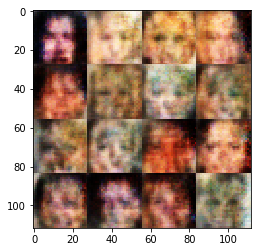

Epoch 1/3 Batch 705 Discriminator Loss: 1.6317 Generator Loss: 2.6921
Epoch 1/3 Batch 710 Discriminator Loss: 1.6694 Generator Loss: 0.4645
Epoch 1/3 Batch 715 Discriminator Loss: 1.5569 Generator Loss: 0.5284
Epoch 1/3 Batch 720 Discriminator Loss: 0.8923 Generator Loss: 1.2553
Epoch 1/3 Batch 725 Discriminator Loss: 1.6283 Generator Loss: 0.5872
Epoch 1/3 Batch 730 Discriminator Loss: 1.2394 Generator Loss: 2.1980
Epoch 1/3 Batch 735 Discriminator Loss: 1.4859 Generator Loss: 0.4727
Epoch 1/3 Batch 740 Discriminator Loss: 1.7357 Generator Loss: 0.6873
Epoch 1/3 Batch 745 Discriminator Loss: 0.8199 Generator Loss: 1.5003
Epoch 1/3 Batch 750 Discriminator Loss: 1.2085 Generator Loss: 0.9025


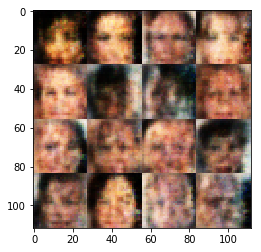

Epoch 1/3 Batch 755 Discriminator Loss: 1.3411 Generator Loss: 1.9864
Epoch 1/3 Batch 760 Discriminator Loss: 1.0396 Generator Loss: 0.8296
Epoch 1/3 Batch 765 Discriminator Loss: 1.3972 Generator Loss: 1.4331
Epoch 1/3 Batch 770 Discriminator Loss: 0.9737 Generator Loss: 0.9009
Epoch 1/3 Batch 775 Discriminator Loss: 1.5556 Generator Loss: 1.5181
Epoch 1/3 Batch 780 Discriminator Loss: 1.3627 Generator Loss: 0.6840
Epoch 1/3 Batch 785 Discriminator Loss: 1.8450 Generator Loss: 0.4139
Epoch 1/3 Batch 790 Discriminator Loss: 1.2261 Generator Loss: 1.7593
Epoch 1/3 Batch 795 Discriminator Loss: 1.2174 Generator Loss: 0.8639
Epoch 1/3 Batch 800 Discriminator Loss: 0.9056 Generator Loss: 1.9154


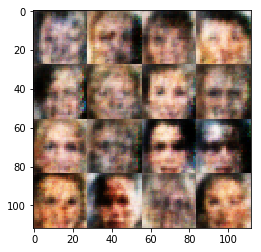

Epoch 1/3 Batch 805 Discriminator Loss: 1.2234 Generator Loss: 0.7504
Epoch 1/3 Batch 810 Discriminator Loss: 1.1400 Generator Loss: 1.6397
Epoch 1/3 Batch 815 Discriminator Loss: 1.0141 Generator Loss: 1.4674
Epoch 1/3 Batch 820 Discriminator Loss: 1.4937 Generator Loss: 0.5267
Epoch 1/3 Batch 825 Discriminator Loss: 1.7997 Generator Loss: 1.4872
Epoch 1/3 Batch 830 Discriminator Loss: 1.1922 Generator Loss: 0.6157
Epoch 1/3 Batch 835 Discriminator Loss: 1.2876 Generator Loss: 1.2079
Epoch 1/3 Batch 840 Discriminator Loss: 1.5811 Generator Loss: 0.5407
Epoch 1/3 Batch 845 Discriminator Loss: 1.5533 Generator Loss: 1.6461
Epoch 1/3 Batch 850 Discriminator Loss: 1.4892 Generator Loss: 0.6140


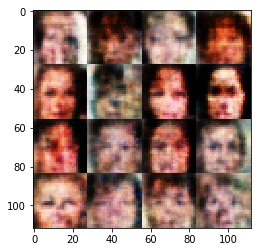

Epoch 1/3 Batch 855 Discriminator Loss: 1.1304 Generator Loss: 0.9045
Epoch 1/3 Batch 860 Discriminator Loss: 1.0608 Generator Loss: 1.4519
Epoch 1/3 Batch 865 Discriminator Loss: 1.0699 Generator Loss: 1.2317
Epoch 1/3 Batch 870 Discriminator Loss: 1.1959 Generator Loss: 0.9014
Epoch 1/3 Batch 875 Discriminator Loss: 1.5596 Generator Loss: 0.5712
Epoch 1/3 Batch 880 Discriminator Loss: 1.0850 Generator Loss: 1.2320
Epoch 1/3 Batch 885 Discriminator Loss: 1.3761 Generator Loss: 1.3741
Epoch 1/3 Batch 890 Discriminator Loss: 1.9267 Generator Loss: 0.4078
Epoch 1/3 Batch 895 Discriminator Loss: 1.1279 Generator Loss: 1.2666
Epoch 1/3 Batch 900 Discriminator Loss: 1.2355 Generator Loss: 0.7259


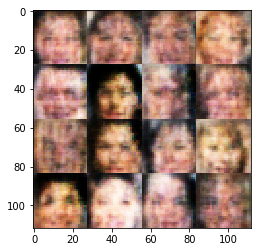

Epoch 1/3 Batch 905 Discriminator Loss: 1.4219 Generator Loss: 1.0835
Epoch 1/3 Batch 910 Discriminator Loss: 0.9801 Generator Loss: 1.0662
Epoch 1/3 Batch 915 Discriminator Loss: 1.0538 Generator Loss: 1.4970
Epoch 1/3 Batch 920 Discriminator Loss: 1.0389 Generator Loss: 1.0245
Epoch 1/3 Batch 925 Discriminator Loss: 1.1877 Generator Loss: 1.3153
Epoch 1/3 Batch 930 Discriminator Loss: 1.4729 Generator Loss: 0.5606
Epoch 1/3 Batch 935 Discriminator Loss: 1.3128 Generator Loss: 0.6307
Epoch 1/3 Batch 940 Discriminator Loss: 1.3144 Generator Loss: 0.9881
Epoch 1/3 Batch 945 Discriminator Loss: 1.5813 Generator Loss: 0.5735
Epoch 1/3 Batch 950 Discriminator Loss: 2.0579 Generator Loss: 1.0556


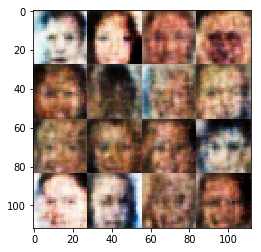

Epoch 1/3 Batch 955 Discriminator Loss: 1.1784 Generator Loss: 1.0122
Epoch 1/3 Batch 960 Discriminator Loss: 1.0579 Generator Loss: 1.3014
Epoch 1/3 Batch 965 Discriminator Loss: 1.4171 Generator Loss: 0.7254
Epoch 1/3 Batch 970 Discriminator Loss: 0.9923 Generator Loss: 1.0466
Epoch 1/3 Batch 975 Discriminator Loss: 1.3173 Generator Loss: 0.9371
Epoch 1/3 Batch 980 Discriminator Loss: 1.5096 Generator Loss: 1.2017
Epoch 1/3 Batch 985 Discriminator Loss: 1.4894 Generator Loss: 0.6804
Epoch 1/3 Batch 990 Discriminator Loss: 1.1857 Generator Loss: 1.0352
Epoch 1/3 Batch 995 Discriminator Loss: 1.0935 Generator Loss: 0.9352
Epoch 1/3 Batch 1000 Discriminator Loss: 1.3693 Generator Loss: 0.6065


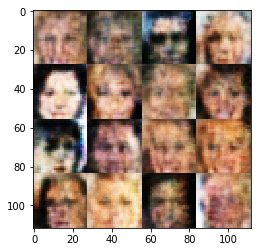

Epoch 1/3 Batch 1005 Discriminator Loss: 1.4527 Generator Loss: 0.6179
Epoch 1/3 Batch 1010 Discriminator Loss: 1.2472 Generator Loss: 1.0368
Epoch 1/3 Batch 1015 Discriminator Loss: 1.4939 Generator Loss: 0.5767
Epoch 1/3 Batch 1020 Discriminator Loss: 1.2226 Generator Loss: 1.2451
Epoch 1/3 Batch 1025 Discriminator Loss: 1.1139 Generator Loss: 1.5235
Epoch 1/3 Batch 1030 Discriminator Loss: 1.3746 Generator Loss: 0.9722
Epoch 1/3 Batch 1035 Discriminator Loss: 1.4557 Generator Loss: 2.1596
Epoch 1/3 Batch 1040 Discriminator Loss: 1.2501 Generator Loss: 0.7509
Epoch 1/3 Batch 1045 Discriminator Loss: 1.2637 Generator Loss: 1.1005
Epoch 1/3 Batch 1050 Discriminator Loss: 1.2736 Generator Loss: 1.0446


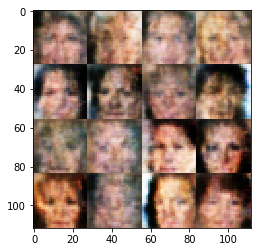

Epoch 1/3 Batch 1055 Discriminator Loss: 1.4884 Generator Loss: 0.5841
Epoch 1/3 Batch 1060 Discriminator Loss: 1.4586 Generator Loss: 1.2036
Epoch 1/3 Batch 1065 Discriminator Loss: 1.0797 Generator Loss: 0.8194
Epoch 1/3 Batch 1070 Discriminator Loss: 1.1145 Generator Loss: 1.1015
Epoch 1/3 Batch 1075 Discriminator Loss: 1.5357 Generator Loss: 1.0955
Epoch 1/3 Batch 1080 Discriminator Loss: 1.7432 Generator Loss: 0.4337
Epoch 1/3 Batch 1085 Discriminator Loss: 1.3167 Generator Loss: 1.1052
Epoch 1/3 Batch 1090 Discriminator Loss: 1.4056 Generator Loss: 0.7964
Epoch 1/3 Batch 1095 Discriminator Loss: 1.2058 Generator Loss: 1.9205
Epoch 1/3 Batch 1100 Discriminator Loss: 1.2729 Generator Loss: 0.7471


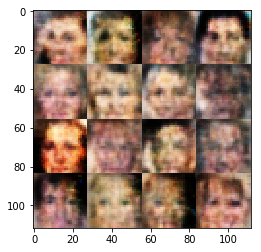

Epoch 1/3 Batch 1105 Discriminator Loss: 1.1452 Generator Loss: 0.8660
Epoch 1/3 Batch 1110 Discriminator Loss: 1.7426 Generator Loss: 0.6660
Epoch 1/3 Batch 1115 Discriminator Loss: 1.6532 Generator Loss: 1.1427
Epoch 1/3 Batch 1120 Discriminator Loss: 1.3148 Generator Loss: 0.9656
Epoch 1/3 Batch 1125 Discriminator Loss: 1.2611 Generator Loss: 0.9002
Epoch 1/3 Batch 1130 Discriminator Loss: 1.1486 Generator Loss: 1.1795
Epoch 1/3 Batch 1135 Discriminator Loss: 1.2651 Generator Loss: 1.1806
Epoch 1/3 Batch 1140 Discriminator Loss: 1.3499 Generator Loss: 0.7139
Epoch 1/3 Batch 1145 Discriminator Loss: 1.4870 Generator Loss: 1.2047
Epoch 1/3 Batch 1150 Discriminator Loss: 1.2173 Generator Loss: 1.0599


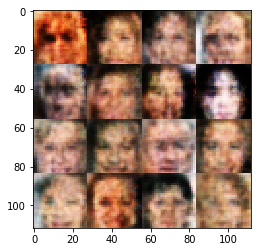

Epoch 1/3 Batch 1155 Discriminator Loss: 0.9844 Generator Loss: 1.2473
Epoch 1/3 Batch 1160 Discriminator Loss: 1.2919 Generator Loss: 0.8112
Epoch 1/3 Batch 1165 Discriminator Loss: 1.4381 Generator Loss: 0.7185
Epoch 1/3 Batch 1170 Discriminator Loss: 1.1335 Generator Loss: 0.8915
Epoch 1/3 Batch 1175 Discriminator Loss: 1.1179 Generator Loss: 0.8719
Epoch 1/3 Batch 1180 Discriminator Loss: 1.2643 Generator Loss: 0.6873
Epoch 1/3 Batch 1185 Discriminator Loss: 1.2171 Generator Loss: 0.9281
Epoch 1/3 Batch 1190 Discriminator Loss: 1.5830 Generator Loss: 0.8453
Epoch 1/3 Batch 1195 Discriminator Loss: 1.3231 Generator Loss: 0.7826
Epoch 1/3 Batch 1200 Discriminator Loss: 1.3320 Generator Loss: 0.8589


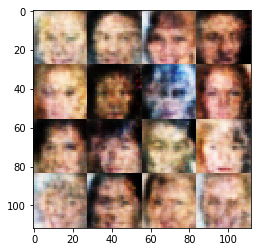

Epoch 1/3 Batch 1205 Discriminator Loss: 1.3442 Generator Loss: 0.9290
Epoch 1/3 Batch 1210 Discriminator Loss: 1.1512 Generator Loss: 1.0788
Epoch 1/3 Batch 1215 Discriminator Loss: 1.4737 Generator Loss: 0.9025
Epoch 1/3 Batch 1220 Discriminator Loss: 1.3777 Generator Loss: 1.0853
Epoch 1/3 Batch 1225 Discriminator Loss: 1.3633 Generator Loss: 1.9981
Epoch 1/3 Batch 1230 Discriminator Loss: 1.3072 Generator Loss: 0.7396
Epoch 1/3 Batch 1235 Discriminator Loss: 1.4191 Generator Loss: 1.1282
Epoch 1/3 Batch 1240 Discriminator Loss: 1.3867 Generator Loss: 0.8699
Epoch 1/3 Batch 1245 Discriminator Loss: 1.5845 Generator Loss: 1.0601
Epoch 1/3 Batch 1250 Discriminator Loss: 1.2802 Generator Loss: 1.1663


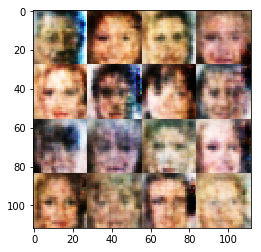

Epoch 1/3 Batch 1255 Discriminator Loss: 1.4466 Generator Loss: 0.9972
Epoch 1/3 Batch 1260 Discriminator Loss: 1.1717 Generator Loss: 0.7791
Epoch 1/3 Batch 1265 Discriminator Loss: 1.3132 Generator Loss: 1.0129
Epoch 1/3 Batch 1270 Discriminator Loss: 1.4539 Generator Loss: 0.7056
Epoch 1/3 Batch 1275 Discriminator Loss: 1.2736 Generator Loss: 0.8647
Epoch 1/3 Batch 1280 Discriminator Loss: 1.3908 Generator Loss: 1.0006
Epoch 1/3 Batch 1285 Discriminator Loss: 1.3789 Generator Loss: 0.8958
Epoch 1/3 Batch 1290 Discriminator Loss: 1.5428 Generator Loss: 0.6571
Epoch 1/3 Batch 1295 Discriminator Loss: 1.2815 Generator Loss: 0.8494
Epoch 1/3 Batch 1300 Discriminator Loss: 1.0317 Generator Loss: 1.5687


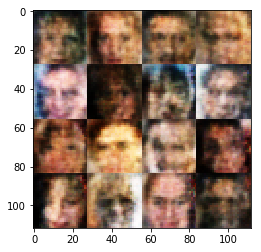

Epoch 1/3 Batch 1305 Discriminator Loss: 1.4226 Generator Loss: 0.6639
Epoch 1/3 Batch 1310 Discriminator Loss: 1.4248 Generator Loss: 0.8695
Epoch 1/3 Batch 1315 Discriminator Loss: 1.4973 Generator Loss: 0.6760
Epoch 1/3 Batch 1320 Discriminator Loss: 1.3464 Generator Loss: 0.9755
Epoch 1/3 Batch 1325 Discriminator Loss: 1.2899 Generator Loss: 0.8537
Epoch 1/3 Batch 1330 Discriminator Loss: 1.4134 Generator Loss: 0.8169
Epoch 1/3 Batch 1335 Discriminator Loss: 1.4367 Generator Loss: 0.7655
Epoch 1/3 Batch 1340 Discriminator Loss: 1.2784 Generator Loss: 1.0170
Epoch 1/3 Batch 1345 Discriminator Loss: 1.1664 Generator Loss: 0.8737
Epoch 1/3 Batch 1350 Discriminator Loss: 1.5818 Generator Loss: 0.7656


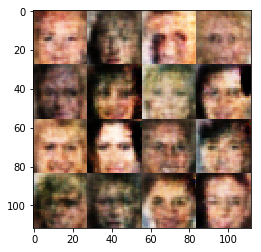

Epoch 1/3 Batch 1355 Discriminator Loss: 1.4641 Generator Loss: 0.5732
Epoch 1/3 Batch 1360 Discriminator Loss: 1.2083 Generator Loss: 1.1055
Epoch 1/3 Batch 1365 Discriminator Loss: 1.4725 Generator Loss: 1.0405
Epoch 1/3 Batch 1370 Discriminator Loss: 1.2609 Generator Loss: 1.0799
Epoch 1/3 Batch 1375 Discriminator Loss: 1.4599 Generator Loss: 0.7677
Epoch 1/3 Batch 1380 Discriminator Loss: 1.3140 Generator Loss: 0.8600
Epoch 1/3 Batch 1385 Discriminator Loss: 1.4174 Generator Loss: 0.6428
Epoch 1/3 Batch 1390 Discriminator Loss: 1.4194 Generator Loss: 0.6958
Epoch 1/3 Batch 1395 Discriminator Loss: 1.3244 Generator Loss: 0.7520
Epoch 1/3 Batch 1400 Discriminator Loss: 1.3910 Generator Loss: 1.0829


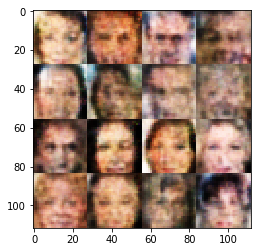

Epoch 1/3 Batch 1405 Discriminator Loss: 1.7131 Generator Loss: 0.6717
Epoch 1/3 Batch 1410 Discriminator Loss: 1.4821 Generator Loss: 0.7947
Epoch 1/3 Batch 1415 Discriminator Loss: 1.4756 Generator Loss: 0.8741
Epoch 1/3 Batch 1420 Discriminator Loss: 1.2332 Generator Loss: 0.9825
Epoch 1/3 Batch 1425 Discriminator Loss: 1.2425 Generator Loss: 0.8634
Epoch 1/3 Batch 1430 Discriminator Loss: 1.1634 Generator Loss: 1.0180
Epoch 1/3 Batch 1435 Discriminator Loss: 1.2782 Generator Loss: 1.0373
Epoch 1/3 Batch 1440 Discriminator Loss: 1.3132 Generator Loss: 0.8564
Epoch 1/3 Batch 1445 Discriminator Loss: 1.5575 Generator Loss: 0.5772
Epoch 1/3 Batch 1450 Discriminator Loss: 1.4224 Generator Loss: 0.9561


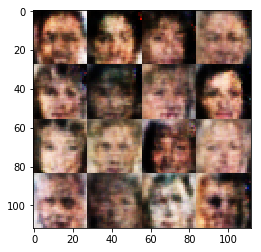

Epoch 1/3 Batch 1455 Discriminator Loss: 1.2681 Generator Loss: 0.8889
Epoch 1/3 Batch 1460 Discriminator Loss: 1.2860 Generator Loss: 0.7649
Epoch 1/3 Batch 1465 Discriminator Loss: 1.2607 Generator Loss: 1.3417
Epoch 1/3 Batch 1470 Discriminator Loss: 1.2630 Generator Loss: 0.9703
Epoch 1/3 Batch 1475 Discriminator Loss: 1.1933 Generator Loss: 0.9376
Epoch 1/3 Batch 1480 Discriminator Loss: 1.3376 Generator Loss: 0.7421
Epoch 1/3 Batch 1485 Discriminator Loss: 1.3910 Generator Loss: 0.7907
Epoch 1/3 Batch 1490 Discriminator Loss: 1.3251 Generator Loss: 0.7284
Epoch 1/3 Batch 1495 Discriminator Loss: 1.4017 Generator Loss: 1.0885
Epoch 1/3 Batch 1500 Discriminator Loss: 1.3172 Generator Loss: 0.7571


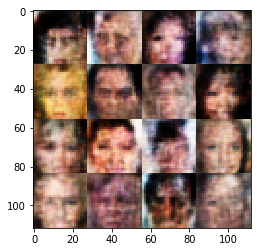

Epoch 1/3 Batch 1505 Discriminator Loss: 1.4022 Generator Loss: 0.9340
Epoch 1/3 Batch 1510 Discriminator Loss: 1.4867 Generator Loss: 0.7816
Epoch 1/3 Batch 1515 Discriminator Loss: 1.4269 Generator Loss: 0.8866
Epoch 1/3 Batch 1520 Discriminator Loss: 1.3466 Generator Loss: 1.0500
Epoch 1/3 Batch 1525 Discriminator Loss: 1.4450 Generator Loss: 0.7690
Epoch 1/3 Batch 1530 Discriminator Loss: 1.3310 Generator Loss: 0.7171
Epoch 1/3 Batch 1535 Discriminator Loss: 1.2674 Generator Loss: 0.8802
Epoch 1/3 Batch 1540 Discriminator Loss: 1.4203 Generator Loss: 0.7918
Epoch 1/3 Batch 1545 Discriminator Loss: 1.2447 Generator Loss: 1.0143
Epoch 1/3 Batch 1550 Discriminator Loss: 1.2523 Generator Loss: 0.8193


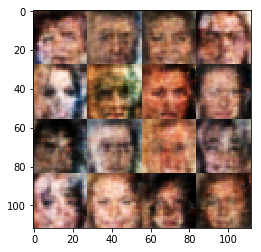

Epoch 1/3 Batch 1555 Discriminator Loss: 1.3595 Generator Loss: 1.0011
Epoch 1/3 Batch 1560 Discriminator Loss: 1.2556 Generator Loss: 0.8478
Epoch 1/3 Batch 1565 Discriminator Loss: 1.1899 Generator Loss: 0.9948
Epoch 1/3 Batch 1570 Discriminator Loss: 1.3521 Generator Loss: 0.9843
Epoch 1/3 Batch 1575 Discriminator Loss: 1.2571 Generator Loss: 1.0467
Epoch 1/3 Batch 1580 Discriminator Loss: 1.3904 Generator Loss: 0.8472
Epoch 1/3 Batch 1585 Discriminator Loss: 1.3228 Generator Loss: 0.8633
Epoch 1/3 Batch 1590 Discriminator Loss: 1.3862 Generator Loss: 0.7632
Epoch 1/3 Batch 1595 Discriminator Loss: 1.3418 Generator Loss: 0.7134
Epoch 1/3 Batch 1600 Discriminator Loss: 1.5209 Generator Loss: 0.7710


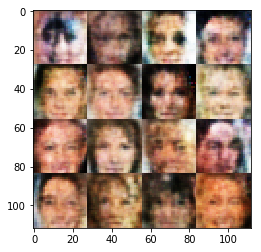

Epoch 1/3 Batch 1605 Discriminator Loss: 1.1936 Generator Loss: 0.9201
Epoch 1/3 Batch 1610 Discriminator Loss: 1.3685 Generator Loss: 0.9791
Epoch 1/3 Batch 1615 Discriminator Loss: 1.2875 Generator Loss: 0.9323
Epoch 1/3 Batch 1620 Discriminator Loss: 1.2131 Generator Loss: 0.9143
Epoch 1/3 Batch 1625 Discriminator Loss: 1.2048 Generator Loss: 0.9377
Epoch 1/3 Batch 1630 Discriminator Loss: 1.4633 Generator Loss: 0.7091
Epoch 1/3 Batch 1635 Discriminator Loss: 1.5346 Generator Loss: 0.6612
Epoch 1/3 Batch 1640 Discriminator Loss: 1.3479 Generator Loss: 0.7670
Epoch 1/3 Batch 1645 Discriminator Loss: 1.3558 Generator Loss: 0.8950
Epoch 1/3 Batch 1650 Discriminator Loss: 1.3758 Generator Loss: 0.8469


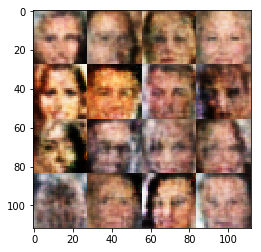

Epoch 1/3 Batch 1655 Discriminator Loss: 1.4028 Generator Loss: 0.8935
Epoch 1/3 Batch 1660 Discriminator Loss: 1.3574 Generator Loss: 0.8477
Epoch 1/3 Batch 1665 Discriminator Loss: 1.2818 Generator Loss: 0.8796
Epoch 1/3 Batch 1670 Discriminator Loss: 1.1966 Generator Loss: 0.7273
Epoch 1/3 Batch 1675 Discriminator Loss: 1.4996 Generator Loss: 0.6501
Epoch 1/3 Batch 1680 Discriminator Loss: 1.3779 Generator Loss: 0.8900
Epoch 1/3 Batch 1685 Discriminator Loss: 1.2767 Generator Loss: 0.8685
Epoch 1/3 Batch 1690 Discriminator Loss: 1.4546 Generator Loss: 0.9669
Epoch 1/3 Batch 1695 Discriminator Loss: 1.1837 Generator Loss: 0.9962
Epoch 1/3 Batch 1700 Discriminator Loss: 1.3663 Generator Loss: 0.7985


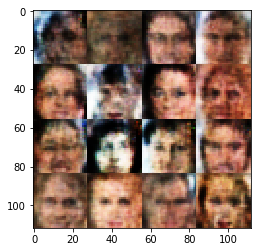

Epoch 1/3 Batch 1705 Discriminator Loss: 1.3402 Generator Loss: 0.9661
Epoch 1/3 Batch 1710 Discriminator Loss: 1.2393 Generator Loss: 0.8081
Epoch 1/3 Batch 1715 Discriminator Loss: 1.2497 Generator Loss: 0.7693
Epoch 1/3 Batch 1720 Discriminator Loss: 1.2856 Generator Loss: 0.6799
Epoch 1/3 Batch 1725 Discriminator Loss: 1.2376 Generator Loss: 0.8873
Epoch 1/3 Batch 1730 Discriminator Loss: 1.1715 Generator Loss: 0.9551
Epoch 1/3 Batch 1735 Discriminator Loss: 1.2580 Generator Loss: 1.0036
Epoch 1/3 Batch 1740 Discriminator Loss: 1.4354 Generator Loss: 0.8600
Epoch 1/3 Batch 1745 Discriminator Loss: 1.3204 Generator Loss: 1.0807
Epoch 1/3 Batch 1750 Discriminator Loss: 1.3311 Generator Loss: 0.7720


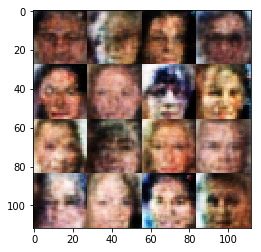

Epoch 1/3 Batch 1755 Discriminator Loss: 1.4456 Generator Loss: 0.9638
Epoch 1/3 Batch 1760 Discriminator Loss: 1.2350 Generator Loss: 1.1028
Epoch 1/3 Batch 1765 Discriminator Loss: 1.5189 Generator Loss: 0.9558
Epoch 1/3 Batch 1770 Discriminator Loss: 1.3034 Generator Loss: 0.8032
Epoch 1/3 Batch 1775 Discriminator Loss: 1.4024 Generator Loss: 0.7147
Epoch 1/3 Batch 1780 Discriminator Loss: 1.3925 Generator Loss: 0.8718
Epoch 1/3 Batch 1785 Discriminator Loss: 1.1645 Generator Loss: 0.9495
Epoch 1/3 Batch 1790 Discriminator Loss: 1.3374 Generator Loss: 0.6926
Epoch 1/3 Batch 1795 Discriminator Loss: 1.3369 Generator Loss: 0.7445
Epoch 1/3 Batch 1800 Discriminator Loss: 1.3505 Generator Loss: 0.7372


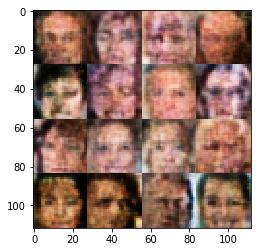

Epoch 1/3 Batch 1805 Discriminator Loss: 1.3289 Generator Loss: 0.7660
Epoch 1/3 Batch 1810 Discriminator Loss: 1.3232 Generator Loss: 1.0912
Epoch 1/3 Batch 1815 Discriminator Loss: 1.3491 Generator Loss: 0.9900
Epoch 1/3 Batch 1820 Discriminator Loss: 1.4037 Generator Loss: 0.7094
Epoch 1/3 Batch 1825 Discriminator Loss: 1.3678 Generator Loss: 0.8825
Epoch 1/3 Batch 1830 Discriminator Loss: 1.3377 Generator Loss: 0.8604
Epoch 1/3 Batch 1835 Discriminator Loss: 1.3313 Generator Loss: 0.7653
Epoch 1/3 Batch 1840 Discriminator Loss: 1.3535 Generator Loss: 1.0094
Epoch 1/3 Batch 1845 Discriminator Loss: 1.3283 Generator Loss: 0.8960
Epoch 1/3 Batch 1850 Discriminator Loss: 1.3706 Generator Loss: 0.6574


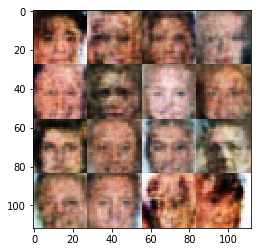

Epoch 1/3 Batch 1855 Discriminator Loss: 1.2867 Generator Loss: 0.7854
Epoch 1/3 Batch 1860 Discriminator Loss: 1.3336 Generator Loss: 0.8349
Epoch 1/3 Batch 1865 Discriminator Loss: 1.3557 Generator Loss: 0.9630
Epoch 1/3 Batch 1870 Discriminator Loss: 1.2747 Generator Loss: 0.8516
Epoch 1/3 Batch 1875 Discriminator Loss: 1.3581 Generator Loss: 0.8185
Epoch 1/3 Batch 1880 Discriminator Loss: 1.3123 Generator Loss: 0.8502
Epoch 1/3 Batch 1885 Discriminator Loss: 1.4179 Generator Loss: 0.8130
Epoch 1/3 Batch 1890 Discriminator Loss: 1.4411 Generator Loss: 0.7111
Epoch 1/3 Batch 1895 Discriminator Loss: 1.3280 Generator Loss: 0.9291
Epoch 1/3 Batch 1900 Discriminator Loss: 1.4502 Generator Loss: 0.9512


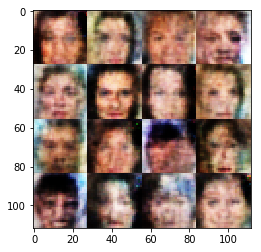

Epoch 1/3 Batch 1905 Discriminator Loss: 1.5638 Generator Loss: 0.7418
Epoch 1/3 Batch 1910 Discriminator Loss: 1.4249 Generator Loss: 0.8420
Epoch 1/3 Batch 1915 Discriminator Loss: 1.2980 Generator Loss: 0.8139
Epoch 1/3 Batch 1920 Discriminator Loss: 1.3309 Generator Loss: 0.8822
Epoch 1/3 Batch 1925 Discriminator Loss: 1.3976 Generator Loss: 0.8001
Epoch 1/3 Batch 1930 Discriminator Loss: 1.3129 Generator Loss: 0.8484
Epoch 1/3 Batch 1935 Discriminator Loss: 1.3698 Generator Loss: 0.8599
Epoch 1/3 Batch 1940 Discriminator Loss: 1.5091 Generator Loss: 0.8340
Epoch 1/3 Batch 1945 Discriminator Loss: 1.4208 Generator Loss: 0.6728
Epoch 1/3 Batch 1950 Discriminator Loss: 1.3828 Generator Loss: 0.7126


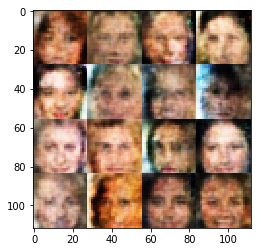

Epoch 1/3 Batch 1955 Discriminator Loss: 1.2965 Generator Loss: 0.7856
Epoch 1/3 Batch 1960 Discriminator Loss: 1.4105 Generator Loss: 0.8837
Epoch 1/3 Batch 1965 Discriminator Loss: 1.3539 Generator Loss: 0.8210
Epoch 1/3 Batch 1970 Discriminator Loss: 1.4118 Generator Loss: 0.8927
Epoch 1/3 Batch 1975 Discriminator Loss: 1.3905 Generator Loss: 0.8101
Epoch 1/3 Batch 1980 Discriminator Loss: 1.4362 Generator Loss: 0.7252
Epoch 1/3 Batch 1985 Discriminator Loss: 1.4336 Generator Loss: 0.7923
Epoch 1/3 Batch 1990 Discriminator Loss: 1.3400 Generator Loss: 0.8109
Epoch 1/3 Batch 1995 Discriminator Loss: 1.3639 Generator Loss: 0.8750
Epoch 1/3 Batch 2000 Discriminator Loss: 1.2870 Generator Loss: 0.8873


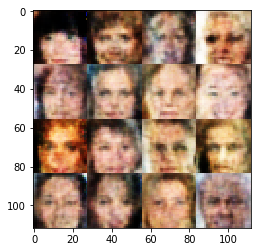

Epoch 1/3 Batch 2005 Discriminator Loss: 1.3369 Generator Loss: 0.7301
Epoch 1/3 Batch 2010 Discriminator Loss: 1.3882 Generator Loss: 0.7939
Epoch 1/3 Batch 2015 Discriminator Loss: 1.2771 Generator Loss: 0.9334
Epoch 1/3 Batch 2020 Discriminator Loss: 1.4571 Generator Loss: 0.6871
Epoch 1/3 Batch 2025 Discriminator Loss: 1.3711 Generator Loss: 0.9283
Epoch 1/3 Batch 2030 Discriminator Loss: 1.4191 Generator Loss: 1.0119
Epoch 1/3 Batch 2035 Discriminator Loss: 1.1972 Generator Loss: 1.0897
Epoch 1/3 Batch 2040 Discriminator Loss: 1.4497 Generator Loss: 0.7022
Epoch 1/3 Batch 2045 Discriminator Loss: 1.3427 Generator Loss: 0.8458
Epoch 1/3 Batch 2050 Discriminator Loss: 1.2695 Generator Loss: 0.7193


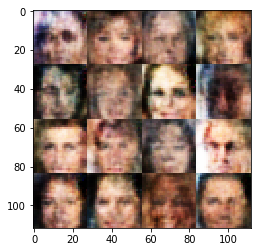

Epoch 1/3 Batch 2055 Discriminator Loss: 1.5014 Generator Loss: 0.8402
Epoch 1/3 Batch 2060 Discriminator Loss: 1.3566 Generator Loss: 0.9233
Epoch 1/3 Batch 2065 Discriminator Loss: 1.3117 Generator Loss: 0.7399
Epoch 1/3 Batch 2070 Discriminator Loss: 1.3945 Generator Loss: 0.7751
Epoch 1/3 Batch 2075 Discriminator Loss: 1.3799 Generator Loss: 0.8810
Epoch 1/3 Batch 2080 Discriminator Loss: 1.2946 Generator Loss: 0.8045
Epoch 1/3 Batch 2085 Discriminator Loss: 1.3991 Generator Loss: 0.6680
Epoch 1/3 Batch 2090 Discriminator Loss: 1.4060 Generator Loss: 1.0790
Epoch 1/3 Batch 2095 Discriminator Loss: 1.3461 Generator Loss: 0.7057
Epoch 1/3 Batch 2100 Discriminator Loss: 1.4050 Generator Loss: 0.7615


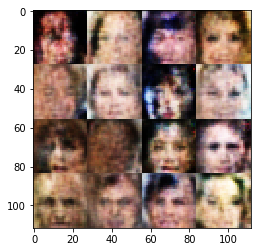

Epoch 1/3 Batch 2105 Discriminator Loss: 1.3521 Generator Loss: 0.8142
Epoch 1/3 Batch 2110 Discriminator Loss: 1.1410 Generator Loss: 0.8435
Epoch 1/3 Batch 2115 Discriminator Loss: 1.3721 Generator Loss: 0.7153
Epoch 1/3 Batch 2120 Discriminator Loss: 1.3268 Generator Loss: 0.9162
Epoch 1/3 Batch 2125 Discriminator Loss: 1.3487 Generator Loss: 1.0776
Epoch 1/3 Batch 2130 Discriminator Loss: 1.4603 Generator Loss: 0.7703
Epoch 1/3 Batch 2135 Discriminator Loss: 1.2714 Generator Loss: 0.8477
Epoch 1/3 Batch 2140 Discriminator Loss: 1.2181 Generator Loss: 0.7957
Epoch 1/3 Batch 2145 Discriminator Loss: 1.4387 Generator Loss: 0.8309
Epoch 1/3 Batch 2150 Discriminator Loss: 1.5114 Generator Loss: 0.9420


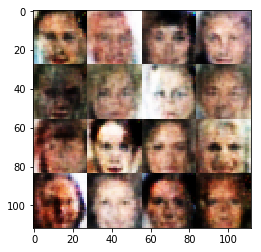

Epoch 1/3 Batch 2155 Discriminator Loss: 1.3119 Generator Loss: 0.7311
Epoch 1/3 Batch 2160 Discriminator Loss: 1.3103 Generator Loss: 0.8927
Epoch 1/3 Batch 2165 Discriminator Loss: 1.3121 Generator Loss: 0.7602
Epoch 1/3 Batch 2170 Discriminator Loss: 1.3297 Generator Loss: 0.8005
Epoch 1/3 Batch 2175 Discriminator Loss: 1.3979 Generator Loss: 0.6953
Epoch 1/3 Batch 2180 Discriminator Loss: 1.3642 Generator Loss: 0.9695
Epoch 1/3 Batch 2185 Discriminator Loss: 1.3773 Generator Loss: 0.7470
Epoch 1/3 Batch 2190 Discriminator Loss: 1.4669 Generator Loss: 0.9278
Epoch 1/3 Batch 2195 Discriminator Loss: 1.3225 Generator Loss: 0.8880
Epoch 1/3 Batch 2200 Discriminator Loss: 1.4775 Generator Loss: 0.7244


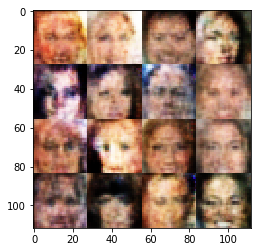

Epoch 1/3 Batch 2205 Discriminator Loss: 1.3909 Generator Loss: 0.8226
Epoch 1/3 Batch 2210 Discriminator Loss: 1.3904 Generator Loss: 0.6879
Epoch 1/3 Batch 2215 Discriminator Loss: 1.2502 Generator Loss: 1.0731
Epoch 1/3 Batch 2220 Discriminator Loss: 1.3900 Generator Loss: 0.7968
Epoch 1/3 Batch 2225 Discriminator Loss: 1.3238 Generator Loss: 0.8615
Epoch 1/3 Batch 2230 Discriminator Loss: 1.4553 Generator Loss: 0.7301
Epoch 1/3 Batch 2235 Discriminator Loss: 1.4009 Generator Loss: 0.8897
Epoch 1/3 Batch 2240 Discriminator Loss: 1.2219 Generator Loss: 0.9014
Epoch 1/3 Batch 2245 Discriminator Loss: 1.4577 Generator Loss: 0.8991
Epoch 1/3 Batch 2250 Discriminator Loss: 1.3874 Generator Loss: 0.8153


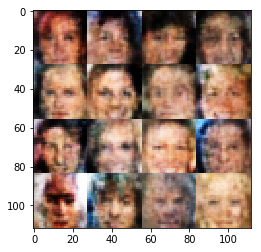

Epoch 1/3 Batch 2255 Discriminator Loss: 1.3953 Generator Loss: 0.7199
Epoch 1/3 Batch 2260 Discriminator Loss: 1.4249 Generator Loss: 0.8551
Epoch 1/3 Batch 2265 Discriminator Loss: 1.3850 Generator Loss: 0.6999
Epoch 1/3 Batch 2270 Discriminator Loss: 1.4536 Generator Loss: 0.8914
Epoch 1/3 Batch 2275 Discriminator Loss: 1.4811 Generator Loss: 0.7152
Epoch 1/3 Batch 2280 Discriminator Loss: 1.3191 Generator Loss: 0.8051
Epoch 1/3 Batch 2285 Discriminator Loss: 1.2538 Generator Loss: 0.9007
Epoch 1/3 Batch 2290 Discriminator Loss: 1.2391 Generator Loss: 0.8461
Epoch 1/3 Batch 2295 Discriminator Loss: 1.2903 Generator Loss: 0.9259
Epoch 1/3 Batch 2300 Discriminator Loss: 1.3994 Generator Loss: 0.8276


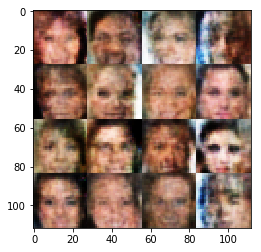

Epoch 1/3 Batch 2305 Discriminator Loss: 1.3152 Generator Loss: 0.7945
Epoch 1/3 Batch 2310 Discriminator Loss: 1.3800 Generator Loss: 0.7369
Epoch 1/3 Batch 2315 Discriminator Loss: 1.4419 Generator Loss: 0.7117
Epoch 1/3 Batch 2320 Discriminator Loss: 1.4255 Generator Loss: 0.7514
Epoch 1/3 Batch 2325 Discriminator Loss: 1.2848 Generator Loss: 0.9142
Epoch 1/3 Batch 2330 Discriminator Loss: 1.3855 Generator Loss: 0.7694
Epoch 1/3 Batch 2335 Discriminator Loss: 1.3478 Generator Loss: 0.7885
Epoch 1/3 Batch 2340 Discriminator Loss: 1.5580 Generator Loss: 0.8056
Epoch 1/3 Batch 2345 Discriminator Loss: 1.3934 Generator Loss: 0.7538
Epoch 1/3 Batch 2350 Discriminator Loss: 1.1689 Generator Loss: 0.9157


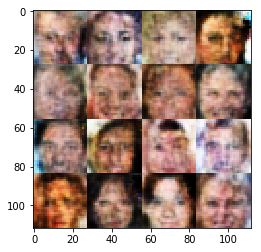

Epoch 1/3 Batch 2355 Discriminator Loss: 1.1921 Generator Loss: 0.9256
Epoch 1/3 Batch 2360 Discriminator Loss: 1.3809 Generator Loss: 0.7380
Epoch 1/3 Batch 2365 Discriminator Loss: 1.4580 Generator Loss: 0.6715
Epoch 1/3 Batch 2370 Discriminator Loss: 1.2776 Generator Loss: 0.9116
Epoch 1/3 Batch 2375 Discriminator Loss: 1.5101 Generator Loss: 0.8277
Epoch 1/3 Batch 2380 Discriminator Loss: 1.3152 Generator Loss: 0.9624
Epoch 1/3 Batch 2385 Discriminator Loss: 1.3583 Generator Loss: 0.8612
Epoch 1/3 Batch 2390 Discriminator Loss: 1.3991 Generator Loss: 0.7761
Epoch 1/3 Batch 2395 Discriminator Loss: 1.4521 Generator Loss: 0.8716
Epoch 1/3 Batch 2400 Discriminator Loss: 1.3414 Generator Loss: 1.0241


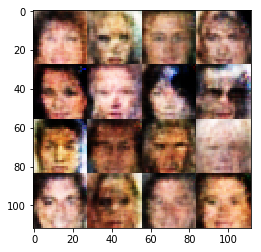

Epoch 1/3 Batch 2405 Discriminator Loss: 1.3635 Generator Loss: 0.9114
Epoch 1/3 Batch 2410 Discriminator Loss: 1.3700 Generator Loss: 0.7910
Epoch 1/3 Batch 2415 Discriminator Loss: 1.3915 Generator Loss: 0.8366
Epoch 1/3 Batch 2420 Discriminator Loss: 1.3955 Generator Loss: 0.8457
Epoch 1/3 Batch 2425 Discriminator Loss: 1.3751 Generator Loss: 0.9241
Epoch 1/3 Batch 2430 Discriminator Loss: 1.2734 Generator Loss: 0.7888
Epoch 1/3 Batch 2435 Discriminator Loss: 1.3959 Generator Loss: 0.7927
Epoch 1/3 Batch 2440 Discriminator Loss: 1.4318 Generator Loss: 0.8151
Epoch 1/3 Batch 2445 Discriminator Loss: 1.2834 Generator Loss: 0.9384
Epoch 1/3 Batch 2450 Discriminator Loss: 1.4281 Generator Loss: 0.7737


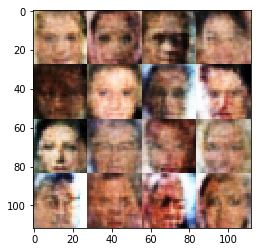

Epoch 1/3 Batch 2455 Discriminator Loss: 1.3385 Generator Loss: 0.7972
Epoch 1/3 Batch 2460 Discriminator Loss: 1.3263 Generator Loss: 0.7964
Epoch 1/3 Batch 2465 Discriminator Loss: 1.3939 Generator Loss: 0.7691
Epoch 1/3 Batch 2470 Discriminator Loss: 1.3957 Generator Loss: 0.7220
Epoch 1/3 Batch 2475 Discriminator Loss: 1.4114 Generator Loss: 0.7383
Epoch 1/3 Batch 2480 Discriminator Loss: 1.3478 Generator Loss: 0.7693
Epoch 1/3 Batch 2485 Discriminator Loss: 1.4147 Generator Loss: 0.8426
Epoch 1/3 Batch 2490 Discriminator Loss: 1.4128 Generator Loss: 0.8143
Epoch 1/3 Batch 2495 Discriminator Loss: 1.3247 Generator Loss: 0.7321
Epoch 1/3 Batch 2500 Discriminator Loss: 1.3191 Generator Loss: 0.7270


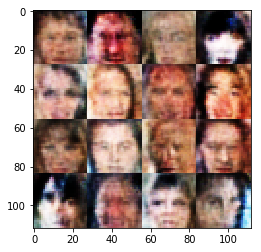

Epoch 1/3 Batch 2505 Discriminator Loss: 1.4279 Generator Loss: 0.7023
Epoch 1/3 Batch 2510 Discriminator Loss: 1.4138 Generator Loss: 0.8849
Epoch 1/3 Batch 2515 Discriminator Loss: 1.4384 Generator Loss: 0.6868
Epoch 1/3 Batch 2520 Discriminator Loss: 1.2977 Generator Loss: 0.8204
Epoch 1/3 Batch 2525 Discriminator Loss: 1.3263 Generator Loss: 0.6887
Epoch 1/3 Batch 2530 Discriminator Loss: 1.2786 Generator Loss: 0.8616
Epoch 1/3 Batch 2535 Discriminator Loss: 1.3518 Generator Loss: 0.7539
Epoch 1/3 Batch 2540 Discriminator Loss: 1.3858 Generator Loss: 0.8776
Epoch 1/3 Batch 2545 Discriminator Loss: 1.4167 Generator Loss: 0.7991
Epoch 1/3 Batch 2550 Discriminator Loss: 1.4244 Generator Loss: 0.8739


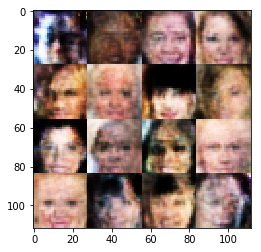

Epoch 1/3 Batch 2555 Discriminator Loss: 1.3256 Generator Loss: 0.7916
Epoch 1/3 Batch 2560 Discriminator Loss: 1.4056 Generator Loss: 0.7859
Epoch 1/3 Batch 2565 Discriminator Loss: 1.2664 Generator Loss: 0.9568
Epoch 1/3 Batch 2570 Discriminator Loss: 1.4119 Generator Loss: 0.7507
Epoch 1/3 Batch 2575 Discriminator Loss: 1.1729 Generator Loss: 0.9550
Epoch 1/3 Batch 2580 Discriminator Loss: 1.3204 Generator Loss: 0.9280
Epoch 1/3 Batch 2585 Discriminator Loss: 1.3807 Generator Loss: 0.7324
Epoch 1/3 Batch 2590 Discriminator Loss: 1.3689 Generator Loss: 0.7736
Epoch 1/3 Batch 2595 Discriminator Loss: 1.3795 Generator Loss: 0.7979
Epoch 1/3 Batch 2600 Discriminator Loss: 1.3971 Generator Loss: 0.7740


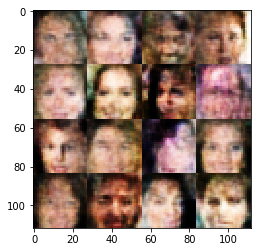

Epoch 1/3 Batch 2605 Discriminator Loss: 1.4667 Generator Loss: 0.7533
Epoch 1/3 Batch 2610 Discriminator Loss: 1.3498 Generator Loss: 0.7852
Epoch 1/3 Batch 2615 Discriminator Loss: 1.2666 Generator Loss: 0.7695
Epoch 1/3 Batch 2620 Discriminator Loss: 1.2963 Generator Loss: 0.9750
Epoch 1/3 Batch 2625 Discriminator Loss: 1.3684 Generator Loss: 0.7942
Epoch 1/3 Batch 2630 Discriminator Loss: 1.4602 Generator Loss: 0.8690
Epoch 1/3 Batch 2635 Discriminator Loss: 1.3851 Generator Loss: 0.7327
Epoch 1/3 Batch 2640 Discriminator Loss: 1.4770 Generator Loss: 0.7941
Epoch 1/3 Batch 2645 Discriminator Loss: 1.3163 Generator Loss: 0.7546
Epoch 1/3 Batch 2650 Discriminator Loss: 1.3099 Generator Loss: 0.8292


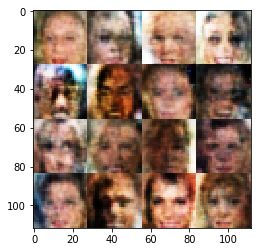

Epoch 1/3 Batch 2655 Discriminator Loss: 1.4243 Generator Loss: 0.8862
Epoch 1/3 Batch 2660 Discriminator Loss: 1.3822 Generator Loss: 0.7590
Epoch 1/3 Batch 2665 Discriminator Loss: 1.4296 Generator Loss: 0.7368
Epoch 1/3 Batch 2670 Discriminator Loss: 1.4732 Generator Loss: 0.9333
Epoch 1/3 Batch 2675 Discriminator Loss: 1.3395 Generator Loss: 0.8522
Epoch 1/3 Batch 2680 Discriminator Loss: 1.3513 Generator Loss: 0.8686
Epoch 1/3 Batch 2685 Discriminator Loss: 1.2905 Generator Loss: 0.7737
Epoch 1/3 Batch 2690 Discriminator Loss: 1.3543 Generator Loss: 0.7770
Epoch 1/3 Batch 2695 Discriminator Loss: 1.4164 Generator Loss: 0.7219
Epoch 1/3 Batch 2700 Discriminator Loss: 1.3477 Generator Loss: 0.7943


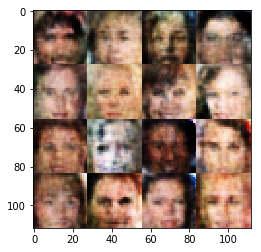

Epoch 1/3 Batch 2705 Discriminator Loss: 1.3204 Generator Loss: 0.8996
Epoch 1/3 Batch 2710 Discriminator Loss: 1.2676 Generator Loss: 0.9340
Epoch 1/3 Batch 2715 Discriminator Loss: 1.3518 Generator Loss: 0.8509
Epoch 1/3 Batch 2720 Discriminator Loss: 1.3626 Generator Loss: 0.8543
Epoch 1/3 Batch 2725 Discriminator Loss: 1.3882 Generator Loss: 0.8493
Epoch 1/3 Batch 2730 Discriminator Loss: 1.3933 Generator Loss: 0.7955
Epoch 1/3 Batch 2735 Discriminator Loss: 1.3723 Generator Loss: 0.8144
Epoch 1/3 Batch 2740 Discriminator Loss: 1.3467 Generator Loss: 0.8505
Epoch 1/3 Batch 2745 Discriminator Loss: 1.3699 Generator Loss: 0.6739
Epoch 1/3 Batch 2750 Discriminator Loss: 1.3810 Generator Loss: 0.7503


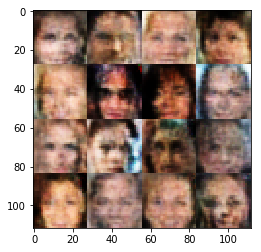

Epoch 1/3 Batch 2755 Discriminator Loss: 1.3110 Generator Loss: 0.8500
Epoch 1/3 Batch 2760 Discriminator Loss: 1.4355 Generator Loss: 0.7592
Epoch 1/3 Batch 2765 Discriminator Loss: 1.4155 Generator Loss: 0.8010
Epoch 1/3 Batch 2770 Discriminator Loss: 1.4366 Generator Loss: 0.7013
Epoch 1/3 Batch 2775 Discriminator Loss: 1.4010 Generator Loss: 0.9195
Epoch 1/3 Batch 2780 Discriminator Loss: 1.2896 Generator Loss: 0.9088
Epoch 1/3 Batch 2785 Discriminator Loss: 1.4409 Generator Loss: 0.6823
Epoch 1/3 Batch 2790 Discriminator Loss: 1.4346 Generator Loss: 0.8479
Epoch 1/3 Batch 2795 Discriminator Loss: 1.4325 Generator Loss: 0.7848
Epoch 1/3 Batch 2800 Discriminator Loss: 1.4678 Generator Loss: 0.8516


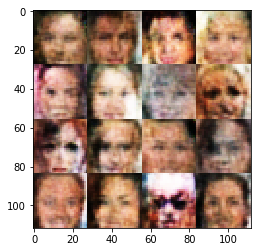

Epoch 1/3 Batch 2805 Discriminator Loss: 1.3011 Generator Loss: 0.9666
Epoch 1/3 Batch 2810 Discriminator Loss: 1.2772 Generator Loss: 0.8357
Epoch 1/3 Batch 2815 Discriminator Loss: 1.3049 Generator Loss: 0.8496
Epoch 1/3 Batch 2820 Discriminator Loss: 1.3235 Generator Loss: 0.7329
Epoch 1/3 Batch 2825 Discriminator Loss: 1.2872 Generator Loss: 0.8040
Epoch 1/3 Batch 2830 Discriminator Loss: 1.3058 Generator Loss: 0.7313
Epoch 1/3 Batch 2835 Discriminator Loss: 1.3288 Generator Loss: 0.6452
Epoch 1/3 Batch 2840 Discriminator Loss: 1.3875 Generator Loss: 0.8395
Epoch 1/3 Batch 2845 Discriminator Loss: 1.2880 Generator Loss: 0.7446
Epoch 1/3 Batch 2850 Discriminator Loss: 1.3937 Generator Loss: 0.8692


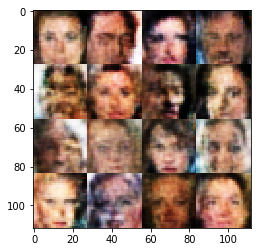

Epoch 1/3 Batch 2855 Discriminator Loss: 1.3663 Generator Loss: 0.9249
Epoch 1/3 Batch 2860 Discriminator Loss: 1.2838 Generator Loss: 0.8668
Epoch 1/3 Batch 2865 Discriminator Loss: 1.4033 Generator Loss: 0.7093
Epoch 1/3 Batch 2870 Discriminator Loss: 1.2882 Generator Loss: 0.8215
Epoch 1/3 Batch 2875 Discriminator Loss: 1.4021 Generator Loss: 0.7777
Epoch 1/3 Batch 2880 Discriminator Loss: 1.5184 Generator Loss: 0.8474
Epoch 1/3 Batch 2885 Discriminator Loss: 1.3110 Generator Loss: 0.8271
Epoch 1/3 Batch 2890 Discriminator Loss: 1.3744 Generator Loss: 0.8999
Epoch 1/3 Batch 2895 Discriminator Loss: 1.3459 Generator Loss: 0.8254
Epoch 1/3 Batch 2900 Discriminator Loss: 1.3870 Generator Loss: 0.9198


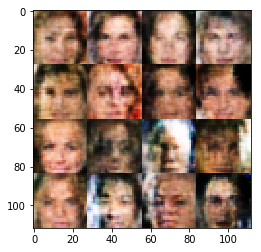

Epoch 1/3 Batch 2905 Discriminator Loss: 1.3840 Generator Loss: 0.7655
Epoch 1/3 Batch 2910 Discriminator Loss: 1.2619 Generator Loss: 0.7848
Epoch 1/3 Batch 2915 Discriminator Loss: 1.3813 Generator Loss: 0.7429
Epoch 1/3 Batch 2920 Discriminator Loss: 1.3033 Generator Loss: 0.8726
Epoch 1/3 Batch 2925 Discriminator Loss: 1.4338 Generator Loss: 0.7780
Epoch 1/3 Batch 2930 Discriminator Loss: 1.3171 Generator Loss: 0.7489
Epoch 1/3 Batch 2935 Discriminator Loss: 1.4099 Generator Loss: 0.8769
Epoch 1/3 Batch 2940 Discriminator Loss: 1.2260 Generator Loss: 0.7962
Epoch 1/3 Batch 2945 Discriminator Loss: 1.3195 Generator Loss: 0.8588
Epoch 1/3 Batch 2950 Discriminator Loss: 1.4425 Generator Loss: 0.7623


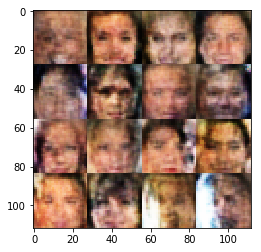

Epoch 1/3 Batch 2955 Discriminator Loss: 1.3099 Generator Loss: 0.8678
Epoch 1/3 Batch 2960 Discriminator Loss: 1.4669 Generator Loss: 0.7867
Epoch 1/3 Batch 2965 Discriminator Loss: 1.4295 Generator Loss: 0.8334
Epoch 1/3 Batch 2970 Discriminator Loss: 1.3411 Generator Loss: 0.9025
Epoch 1/3 Batch 2975 Discriminator Loss: 1.3252 Generator Loss: 0.7511
Epoch 1/3 Batch 2980 Discriminator Loss: 1.3276 Generator Loss: 0.8871
Epoch 1/3 Batch 2985 Discriminator Loss: 1.3571 Generator Loss: 0.7958
Epoch 1/3 Batch 2990 Discriminator Loss: 1.3897 Generator Loss: 0.7787
Epoch 1/3 Batch 2995 Discriminator Loss: 1.3160 Generator Loss: 0.7713
Epoch 1/3 Batch 3000 Discriminator Loss: 1.3534 Generator Loss: 0.7880


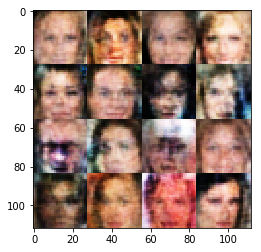

Epoch 1/3 Batch 3005 Discriminator Loss: 1.3376 Generator Loss: 0.8915
Epoch 1/3 Batch 3010 Discriminator Loss: 1.4006 Generator Loss: 0.7504
Epoch 1/3 Batch 3015 Discriminator Loss: 1.3824 Generator Loss: 0.8075
Epoch 1/3 Batch 3020 Discriminator Loss: 1.4477 Generator Loss: 0.7803
Epoch 1/3 Batch 3025 Discriminator Loss: 1.3631 Generator Loss: 0.7415
Epoch 1/3 Batch 3030 Discriminator Loss: 1.5328 Generator Loss: 0.7581
Epoch 1/3 Batch 3035 Discriminator Loss: 1.2976 Generator Loss: 0.8463
Epoch 1/3 Batch 3040 Discriminator Loss: 1.4630 Generator Loss: 0.7188
Epoch 1/3 Batch 3045 Discriminator Loss: 1.4515 Generator Loss: 0.7743
Epoch 1/3 Batch 3050 Discriminator Loss: 1.3479 Generator Loss: 0.8169


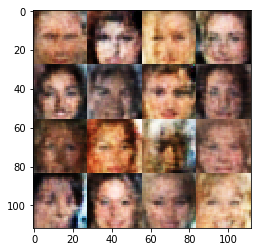

Epoch 1/3 Batch 3055 Discriminator Loss: 1.3054 Generator Loss: 0.7751
Epoch 1/3 Batch 3060 Discriminator Loss: 1.4009 Generator Loss: 0.6838
Epoch 1/3 Batch 3065 Discriminator Loss: 1.2945 Generator Loss: 0.8634
Epoch 1/3 Batch 3070 Discriminator Loss: 1.4394 Generator Loss: 0.8475
Epoch 1/3 Batch 3075 Discriminator Loss: 1.3878 Generator Loss: 0.7414
Epoch 1/3 Batch 3080 Discriminator Loss: 1.2940 Generator Loss: 0.8121
Epoch 1/3 Batch 3085 Discriminator Loss: 1.3149 Generator Loss: 0.9127
Epoch 1/3 Batch 3090 Discriminator Loss: 1.3709 Generator Loss: 0.7352
Epoch 1/3 Batch 3095 Discriminator Loss: 1.3183 Generator Loss: 0.8491
Epoch 1/3 Batch 3100 Discriminator Loss: 1.3905 Generator Loss: 0.7898


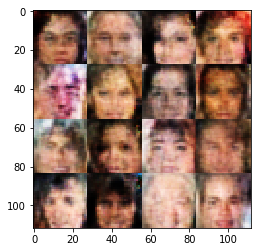

Epoch 1/3 Batch 3105 Discriminator Loss: 1.3710 Generator Loss: 0.7904
Epoch 1/3 Batch 3110 Discriminator Loss: 1.4278 Generator Loss: 0.8716
Epoch 1/3 Batch 3115 Discriminator Loss: 1.3680 Generator Loss: 0.8768
Epoch 1/3 Batch 3120 Discriminator Loss: 1.3564 Generator Loss: 0.7620
Epoch 1/3 Batch 3125 Discriminator Loss: 1.3724 Generator Loss: 0.8862
Epoch 1/3 Batch 3130 Discriminator Loss: 1.3858 Generator Loss: 0.8138
Epoch 1/3 Batch 3135 Discriminator Loss: 1.3291 Generator Loss: 0.8836
Epoch 1/3 Batch 3140 Discriminator Loss: 1.3933 Generator Loss: 0.7383
Epoch 1/3 Batch 3145 Discriminator Loss: 1.3955 Generator Loss: 0.7389
Epoch 1/3 Batch 3150 Discriminator Loss: 1.4011 Generator Loss: 0.7996


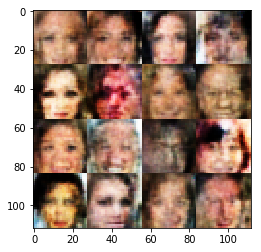

Epoch 1/3 Batch 3155 Discriminator Loss: 1.3343 Generator Loss: 0.7601
Epoch 1/3 Batch 3160 Discriminator Loss: 1.3737 Generator Loss: 0.9032
Epoch 1/3 Batch 3165 Discriminator Loss: 1.4294 Generator Loss: 0.8568
Epoch 1/3 Batch 3170 Discriminator Loss: 1.2980 Generator Loss: 0.8493
Epoch 1/3 Batch 3175 Discriminator Loss: 1.5902 Generator Loss: 0.8116
Epoch 1/3 Batch 3180 Discriminator Loss: 1.3541 Generator Loss: 0.7604
Epoch 1/3 Batch 3185 Discriminator Loss: 1.4398 Generator Loss: 0.7514
Epoch 1/3 Batch 3190 Discriminator Loss: 1.3772 Generator Loss: 0.7384
Epoch 1/3 Batch 3195 Discriminator Loss: 1.4202 Generator Loss: 0.7354
Epoch 1/3 Batch 3200 Discriminator Loss: 1.2786 Generator Loss: 0.8097


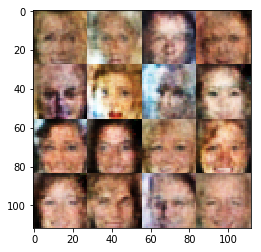

Epoch 1/3 Batch 3205 Discriminator Loss: 1.4619 Generator Loss: 0.6922
Epoch 1/3 Batch 3210 Discriminator Loss: 1.3883 Generator Loss: 0.9530
Epoch 1/3 Batch 3215 Discriminator Loss: 1.3195 Generator Loss: 0.8931
Epoch 1/3 Batch 3220 Discriminator Loss: 1.3243 Generator Loss: 0.6941
Epoch 1/3 Batch 3225 Discriminator Loss: 1.2838 Generator Loss: 0.7949
Epoch 1/3 Batch 3230 Discriminator Loss: 1.2657 Generator Loss: 0.7005
Epoch 1/3 Batch 3235 Discriminator Loss: 1.3542 Generator Loss: 0.9185
Epoch 1/3 Batch 3240 Discriminator Loss: 1.3313 Generator Loss: 0.8857
Epoch 1/3 Batch 3245 Discriminator Loss: 1.3784 Generator Loss: 0.6447
Epoch 1/3 Batch 3250 Discriminator Loss: 1.4175 Generator Loss: 0.8067


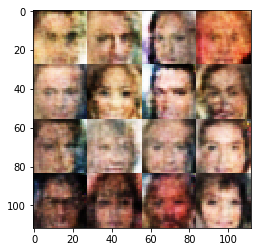

Epoch 1/3 Batch 3255 Discriminator Loss: 1.4305 Generator Loss: 0.7595
Epoch 1/3 Batch 3260 Discriminator Loss: 1.4906 Generator Loss: 0.8327
Epoch 1/3 Batch 3265 Discriminator Loss: 1.4093 Generator Loss: 0.8568
Epoch 1/3 Batch 3270 Discriminator Loss: 1.2965 Generator Loss: 0.9638
Epoch 1/3 Batch 3275 Discriminator Loss: 1.2955 Generator Loss: 0.7685
Epoch 1/3 Batch 3280 Discriminator Loss: 1.3121 Generator Loss: 0.7365
Epoch 1/3 Batch 3285 Discriminator Loss: 1.4019 Generator Loss: 0.7880
Epoch 1/3 Batch 3290 Discriminator Loss: 1.2972 Generator Loss: 0.7710
Epoch 1/3 Batch 3295 Discriminator Loss: 1.3893 Generator Loss: 0.8133
Epoch 1/3 Batch 3300 Discriminator Loss: 1.4136 Generator Loss: 0.7519


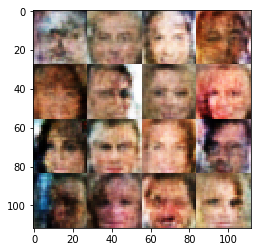

Epoch 1/3 Batch 3305 Discriminator Loss: 1.3939 Generator Loss: 0.7949
Epoch 1/3 Batch 3310 Discriminator Loss: 1.3290 Generator Loss: 0.8054
Epoch 1/3 Batch 3315 Discriminator Loss: 1.3302 Generator Loss: 0.7385
Epoch 1/3 Batch 3320 Discriminator Loss: 1.3963 Generator Loss: 0.8610
Epoch 1/3 Batch 3325 Discriminator Loss: 1.3922 Generator Loss: 0.6612
Epoch 1/3 Batch 3330 Discriminator Loss: 1.3745 Generator Loss: 0.7478
Epoch 1/3 Batch 3335 Discriminator Loss: 1.4302 Generator Loss: 0.7060
Epoch 1/3 Batch 3340 Discriminator Loss: 1.3520 Generator Loss: 0.7825
Epoch 1/3 Batch 3345 Discriminator Loss: 1.4077 Generator Loss: 0.8470
Epoch 1/3 Batch 3350 Discriminator Loss: 1.3566 Generator Loss: 0.7465


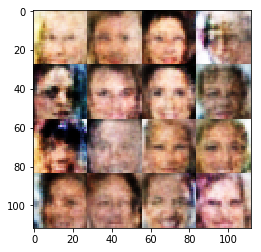

Epoch 1/3 Batch 3355 Discriminator Loss: 1.3262 Generator Loss: 0.8301
Epoch 1/3 Batch 3360 Discriminator Loss: 1.4202 Generator Loss: 0.7355
Epoch 1/3 Batch 3365 Discriminator Loss: 1.2894 Generator Loss: 0.7974
Epoch 1/3 Batch 3370 Discriminator Loss: 1.3408 Generator Loss: 0.6844
Epoch 1/3 Batch 3375 Discriminator Loss: 1.3691 Generator Loss: 0.9442
Epoch 1/3 Batch 3380 Discriminator Loss: 1.3872 Generator Loss: 0.7968
Epoch 1/3 Batch 3385 Discriminator Loss: 1.3784 Generator Loss: 0.8073
Epoch 1/3 Batch 3390 Discriminator Loss: 1.3886 Generator Loss: 0.8364
Epoch 1/3 Batch 3395 Discriminator Loss: 1.3536 Generator Loss: 0.7725
Epoch 1/3 Batch 3400 Discriminator Loss: 1.3720 Generator Loss: 0.8188


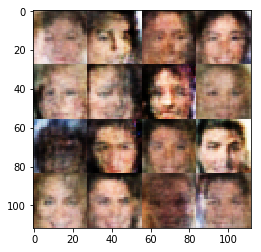

Epoch 1/3 Batch 3405 Discriminator Loss: 1.3217 Generator Loss: 0.8545
Epoch 1/3 Batch 3410 Discriminator Loss: 1.2598 Generator Loss: 0.8390
Epoch 1/3 Batch 3415 Discriminator Loss: 1.3627 Generator Loss: 0.7238
Epoch 1/3 Batch 3420 Discriminator Loss: 1.3546 Generator Loss: 0.7990
Epoch 1/3 Batch 3425 Discriminator Loss: 1.3819 Generator Loss: 0.7657
Epoch 1/3 Batch 3430 Discriminator Loss: 1.3451 Generator Loss: 0.7770
Epoch 1/3 Batch 3435 Discriminator Loss: 1.3434 Generator Loss: 0.8588
Epoch 1/3 Batch 3440 Discriminator Loss: 1.3302 Generator Loss: 0.8590
Epoch 1/3 Batch 3445 Discriminator Loss: 1.2540 Generator Loss: 0.8063
Epoch 1/3 Batch 3450 Discriminator Loss: 1.3429 Generator Loss: 0.7741


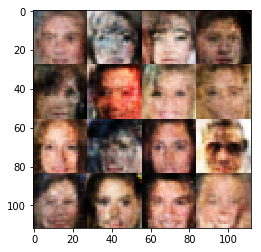

Epoch 1/3 Batch 3455 Discriminator Loss: 1.3668 Generator Loss: 0.8463
Epoch 1/3 Batch 3460 Discriminator Loss: 1.3202 Generator Loss: 0.7302
Epoch 1/3 Batch 3465 Discriminator Loss: 1.3376 Generator Loss: 0.6873
Epoch 1/3 Batch 3470 Discriminator Loss: 1.3713 Generator Loss: 0.8298
Epoch 1/3 Batch 3475 Discriminator Loss: 1.3509 Generator Loss: 0.9334
Epoch 1/3 Batch 3480 Discriminator Loss: 1.2558 Generator Loss: 0.8320
Epoch 1/3 Batch 3485 Discriminator Loss: 1.3920 Generator Loss: 0.7586
Epoch 1/3 Batch 3490 Discriminator Loss: 1.4708 Generator Loss: 0.8223
Epoch 1/3 Batch 3495 Discriminator Loss: 1.3915 Generator Loss: 0.7801
Epoch 1/3 Batch 3500 Discriminator Loss: 1.3896 Generator Loss: 0.7422


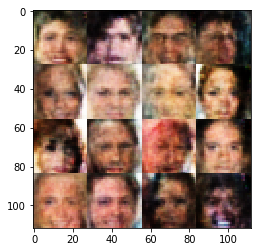

Epoch 1/3 Batch 3505 Discriminator Loss: 1.4264 Generator Loss: 0.7534
Epoch 1/3 Batch 3510 Discriminator Loss: 1.4703 Generator Loss: 0.8062
Epoch 1/3 Batch 3515 Discriminator Loss: 1.3445 Generator Loss: 0.8800
Epoch 1/3 Batch 3520 Discriminator Loss: 1.3165 Generator Loss: 0.7493
Epoch 1/3 Batch 3525 Discriminator Loss: 1.3185 Generator Loss: 0.8472
Epoch 1/3 Batch 3530 Discriminator Loss: 1.3519 Generator Loss: 0.7674
Epoch 1/3 Batch 3535 Discriminator Loss: 1.2964 Generator Loss: 0.8279
Epoch 1/3 Batch 3540 Discriminator Loss: 1.3009 Generator Loss: 0.7649
Epoch 1/3 Batch 3545 Discriminator Loss: 1.3545 Generator Loss: 0.8194
Epoch 1/3 Batch 3550 Discriminator Loss: 1.3680 Generator Loss: 0.8864


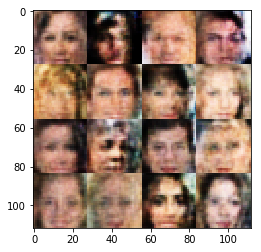

Epoch 1/3 Batch 3555 Discriminator Loss: 1.3478 Generator Loss: 0.7680
Epoch 1/3 Batch 3560 Discriminator Loss: 1.3477 Generator Loss: 0.7606
Epoch 1/3 Batch 3565 Discriminator Loss: 1.4281 Generator Loss: 0.6870
Epoch 1/3 Batch 3570 Discriminator Loss: 1.3726 Generator Loss: 0.8054
Epoch 1/3 Batch 3575 Discriminator Loss: 1.4127 Generator Loss: 0.6851
Epoch 1/3 Batch 3580 Discriminator Loss: 1.4040 Generator Loss: 0.8206
Epoch 1/3 Batch 3585 Discriminator Loss: 1.3374 Generator Loss: 0.7374
Epoch 1/3 Batch 3590 Discriminator Loss: 1.4232 Generator Loss: 0.7007
Epoch 1/3 Batch 3595 Discriminator Loss: 1.4215 Generator Loss: 0.7847
Epoch 1/3 Batch 3600 Discriminator Loss: 1.3340 Generator Loss: 0.7177


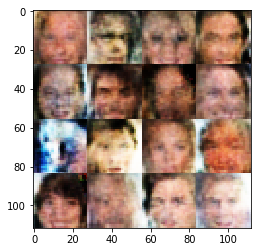

Epoch 1/3 Batch 3605 Discriminator Loss: 1.4172 Generator Loss: 0.8056
Epoch 1/3 Batch 3610 Discriminator Loss: 1.3899 Generator Loss: 0.7735
Epoch 1/3 Batch 3615 Discriminator Loss: 1.3477 Generator Loss: 0.8183
Epoch 1/3 Batch 3620 Discriminator Loss: 1.4646 Generator Loss: 0.7402
Epoch 1/3 Batch 3625 Discriminator Loss: 1.4351 Generator Loss: 0.8653
Epoch 1/3 Batch 3630 Discriminator Loss: 1.3162 Generator Loss: 0.7021
Epoch 1/3 Batch 3635 Discriminator Loss: 1.2966 Generator Loss: 0.7256
Epoch 1/3 Batch 3640 Discriminator Loss: 1.3712 Generator Loss: 0.8006
Epoch 1/3 Batch 3645 Discriminator Loss: 1.3621 Generator Loss: 0.8166
Epoch 1/3 Batch 3650 Discriminator Loss: 1.4335 Generator Loss: 0.8190


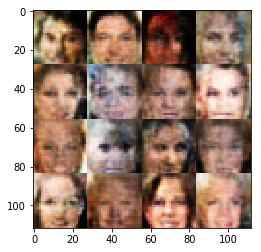

Epoch 1/3 Batch 3655 Discriminator Loss: 1.2960 Generator Loss: 0.9048
Epoch 1/3 Batch 3660 Discriminator Loss: 1.4039 Generator Loss: 0.8874
Epoch 1/3 Batch 3665 Discriminator Loss: 1.3910 Generator Loss: 0.8011
Epoch 1/3 Batch 3670 Discriminator Loss: 1.2822 Generator Loss: 0.8007
Epoch 1/3 Batch 3675 Discriminator Loss: 1.3624 Generator Loss: 0.8523
Epoch 1/3 Batch 3680 Discriminator Loss: 1.3751 Generator Loss: 0.7089
Epoch 1/3 Batch 3685 Discriminator Loss: 1.3831 Generator Loss: 0.6778
Epoch 1/3 Batch 3690 Discriminator Loss: 1.3335 Generator Loss: 0.7458
Epoch 1/3 Batch 3695 Discriminator Loss: 1.4787 Generator Loss: 0.7577
Epoch 1/3 Batch 3700 Discriminator Loss: 1.2738 Generator Loss: 0.8179


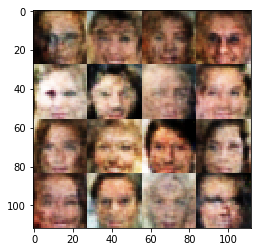

Epoch 1/3 Batch 3705 Discriminator Loss: 1.4025 Generator Loss: 0.8282
Epoch 1/3 Batch 3710 Discriminator Loss: 1.4025 Generator Loss: 0.8320
Epoch 1/3 Batch 3715 Discriminator Loss: 1.4274 Generator Loss: 0.7731
Epoch 1/3 Batch 3720 Discriminator Loss: 1.5085 Generator Loss: 0.8549
Epoch 1/3 Batch 3725 Discriminator Loss: 1.4116 Generator Loss: 0.8588
Epoch 1/3 Batch 3730 Discriminator Loss: 1.3591 Generator Loss: 0.7737
Epoch 1/3 Batch 3735 Discriminator Loss: 1.3156 Generator Loss: 0.9000
Epoch 1/3 Batch 3740 Discriminator Loss: 1.4296 Generator Loss: 0.8268
Epoch 1/3 Batch 3745 Discriminator Loss: 1.3555 Generator Loss: 0.8410
Epoch 1/3 Batch 3750 Discriminator Loss: 1.2823 Generator Loss: 0.8068


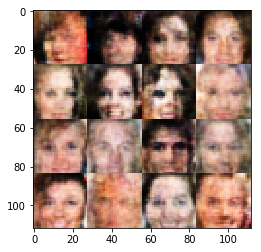

Epoch 1/3 Batch 3755 Discriminator Loss: 1.3032 Generator Loss: 0.8868
Epoch 1/3 Batch 3760 Discriminator Loss: 1.3322 Generator Loss: 0.7974
Epoch 1/3 Batch 3765 Discriminator Loss: 1.4127 Generator Loss: 0.6992
Epoch 1/3 Batch 3770 Discriminator Loss: 1.4146 Generator Loss: 0.7814
Epoch 1/3 Batch 3775 Discriminator Loss: 1.3683 Generator Loss: 0.9002
Epoch 1/3 Batch 3780 Discriminator Loss: 1.3865 Generator Loss: 0.8043
Epoch 1/3 Batch 3785 Discriminator Loss: 1.3547 Generator Loss: 0.7911
Epoch 1/3 Batch 3790 Discriminator Loss: 1.4224 Generator Loss: 0.7990
Epoch 1/3 Batch 3795 Discriminator Loss: 1.3959 Generator Loss: 0.8209
Epoch 1/3 Batch 3800 Discriminator Loss: 1.4752 Generator Loss: 0.8321


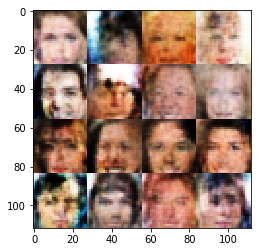

Epoch 1/3 Batch 3805 Discriminator Loss: 1.3953 Generator Loss: 0.7287
Epoch 1/3 Batch 3810 Discriminator Loss: 1.4594 Generator Loss: 0.6955
Epoch 1/3 Batch 3815 Discriminator Loss: 1.3904 Generator Loss: 0.8096
Epoch 1/3 Batch 3820 Discriminator Loss: 1.4295 Generator Loss: 0.7542
Epoch 1/3 Batch 3825 Discriminator Loss: 1.3762 Generator Loss: 0.8491
Epoch 1/3 Batch 3830 Discriminator Loss: 1.4611 Generator Loss: 0.6815
Epoch 1/3 Batch 3835 Discriminator Loss: 1.4655 Generator Loss: 0.7341
Epoch 1/3 Batch 3840 Discriminator Loss: 1.2777 Generator Loss: 0.7981
Epoch 1/3 Batch 3845 Discriminator Loss: 1.3929 Generator Loss: 0.7479
Epoch 1/3 Batch 3850 Discriminator Loss: 1.2938 Generator Loss: 0.7937


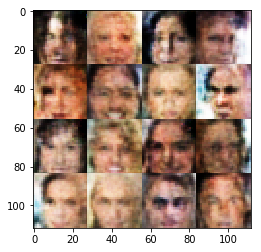

Epoch 1/3 Batch 3855 Discriminator Loss: 1.3250 Generator Loss: 0.7685
Epoch 1/3 Batch 3860 Discriminator Loss: 1.4509 Generator Loss: 0.7057
Epoch 1/3 Batch 3865 Discriminator Loss: 1.3773 Generator Loss: 0.8486
Epoch 1/3 Batch 3870 Discriminator Loss: 1.3823 Generator Loss: 0.7661
Epoch 1/3 Batch 3875 Discriminator Loss: 1.3110 Generator Loss: 0.7161
Epoch 1/3 Batch 3880 Discriminator Loss: 1.3746 Generator Loss: 0.8069
Epoch 1/3 Batch 3885 Discriminator Loss: 1.3156 Generator Loss: 0.9538
Epoch 1/3 Batch 3890 Discriminator Loss: 1.3992 Generator Loss: 0.8089
Epoch 1/3 Batch 3895 Discriminator Loss: 1.3473 Generator Loss: 0.7287
Epoch 1/3 Batch 3900 Discriminator Loss: 1.4342 Generator Loss: 0.7669


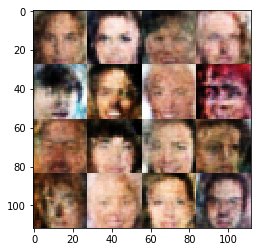

Epoch 1/3 Batch 3905 Discriminator Loss: 1.3295 Generator Loss: 0.7938
Epoch 1/3 Batch 3910 Discriminator Loss: 1.3591 Generator Loss: 0.8034
Epoch 1/3 Batch 3915 Discriminator Loss: 1.4349 Generator Loss: 0.6922
Epoch 1/3 Batch 3920 Discriminator Loss: 1.2869 Generator Loss: 0.8523
Epoch 1/3 Batch 3925 Discriminator Loss: 1.2964 Generator Loss: 0.8322
Epoch 1/3 Batch 3930 Discriminator Loss: 1.4026 Generator Loss: 0.7914
Epoch 1/3 Batch 3935 Discriminator Loss: 1.4027 Generator Loss: 0.8100
Epoch 1/3 Batch 3940 Discriminator Loss: 1.3449 Generator Loss: 0.7861
Epoch 1/3 Batch 3945 Discriminator Loss: 1.4200 Generator Loss: 0.7705
Epoch 1/3 Batch 3950 Discriminator Loss: 1.3848 Generator Loss: 0.8492


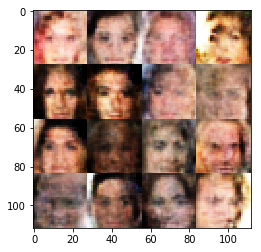

Epoch 1/3 Batch 3955 Discriminator Loss: 1.3685 Generator Loss: 0.7265
Epoch 1/3 Batch 3960 Discriminator Loss: 1.3979 Generator Loss: 0.7184
Epoch 1/3 Batch 3965 Discriminator Loss: 1.4229 Generator Loss: 0.8997
Epoch 1/3 Batch 3970 Discriminator Loss: 1.3877 Generator Loss: 0.7955
Epoch 1/3 Batch 3975 Discriminator Loss: 1.3325 Generator Loss: 0.7021
Epoch 1/3 Batch 3980 Discriminator Loss: 1.3932 Generator Loss: 0.7375
Epoch 1/3 Batch 3985 Discriminator Loss: 1.3924 Generator Loss: 0.7506
Epoch 1/3 Batch 3990 Discriminator Loss: 1.3483 Generator Loss: 0.8672
Epoch 1/3 Batch 3995 Discriminator Loss: 1.3714 Generator Loss: 0.8320
Epoch 1/3 Batch 4000 Discriminator Loss: 1.3945 Generator Loss: 0.8123


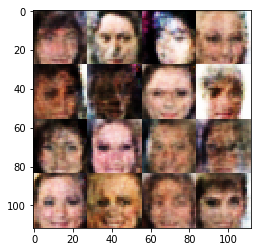

Epoch 1/3 Batch 4005 Discriminator Loss: 1.4146 Generator Loss: 0.9085
Epoch 1/3 Batch 4010 Discriminator Loss: 1.2259 Generator Loss: 0.8933
Epoch 1/3 Batch 4015 Discriminator Loss: 1.3349 Generator Loss: 0.7941
Epoch 1/3 Batch 4020 Discriminator Loss: 1.3765 Generator Loss: 0.7691
Epoch 1/3 Batch 4025 Discriminator Loss: 1.3863 Generator Loss: 0.8800
Epoch 1/3 Batch 4030 Discriminator Loss: 1.3006 Generator Loss: 0.7690
Epoch 1/3 Batch 4035 Discriminator Loss: 1.3753 Generator Loss: 0.7870
Epoch 1/3 Batch 4040 Discriminator Loss: 1.3471 Generator Loss: 0.8302
Epoch 1/3 Batch 4045 Discriminator Loss: 1.3437 Generator Loss: 0.7774
Epoch 1/3 Batch 4050 Discriminator Loss: 1.3396 Generator Loss: 0.8575


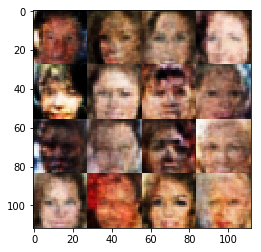

Epoch 1/3 Batch 4055 Discriminator Loss: 1.3273 Generator Loss: 0.7661
Epoch 1/3 Batch 4060 Discriminator Loss: 1.4259 Generator Loss: 0.7970
Epoch 1/3 Batch 4065 Discriminator Loss: 1.3502 Generator Loss: 0.7423
Epoch 1/3 Batch 4070 Discriminator Loss: 1.4240 Generator Loss: 0.8508
Epoch 1/3 Batch 4075 Discriminator Loss: 1.3420 Generator Loss: 0.7980
Epoch 1/3 Batch 4080 Discriminator Loss: 1.3424 Generator Loss: 0.7273
Epoch 1/3 Batch 4085 Discriminator Loss: 1.3569 Generator Loss: 0.8239
Epoch 1/3 Batch 4090 Discriminator Loss: 1.3437 Generator Loss: 0.7491
Epoch 1/3 Batch 4095 Discriminator Loss: 1.3535 Generator Loss: 0.7182
Epoch 1/3 Batch 4100 Discriminator Loss: 1.3704 Generator Loss: 0.7077


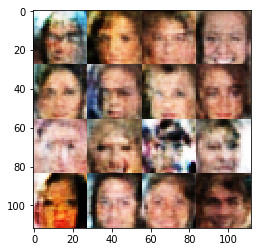

Epoch 1/3 Batch 4105 Discriminator Loss: 1.3600 Generator Loss: 0.7870
Epoch 1/3 Batch 4110 Discriminator Loss: 1.4049 Generator Loss: 0.7622
Epoch 1/3 Batch 4115 Discriminator Loss: 1.3900 Generator Loss: 0.7739
Epoch 1/3 Batch 4120 Discriminator Loss: 1.4142 Generator Loss: 0.8035
Epoch 1/3 Batch 4125 Discriminator Loss: 1.4182 Generator Loss: 0.8023
Epoch 1/3 Batch 4130 Discriminator Loss: 1.3822 Generator Loss: 0.8020
Epoch 1/3 Batch 4135 Discriminator Loss: 1.3123 Generator Loss: 0.7661
Epoch 1/3 Batch 4140 Discriminator Loss: 1.3385 Generator Loss: 0.8131
Epoch 1/3 Batch 4145 Discriminator Loss: 1.3263 Generator Loss: 0.8316
Epoch 1/3 Batch 4150 Discriminator Loss: 1.4118 Generator Loss: 0.7676


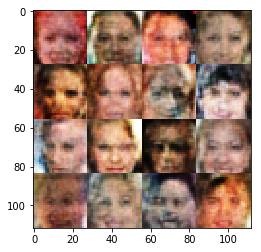

Epoch 1/3 Batch 4155 Discriminator Loss: 1.4048 Generator Loss: 0.7904
Epoch 1/3 Batch 4160 Discriminator Loss: 1.4155 Generator Loss: 0.8293
Epoch 1/3 Batch 4165 Discriminator Loss: 1.4238 Generator Loss: 0.6612
Epoch 1/3 Batch 4170 Discriminator Loss: 1.3364 Generator Loss: 0.8469
Epoch 1/3 Batch 4175 Discriminator Loss: 1.2764 Generator Loss: 0.8636
Epoch 1/3 Batch 4180 Discriminator Loss: 1.3965 Generator Loss: 0.9003
Epoch 1/3 Batch 4185 Discriminator Loss: 1.3631 Generator Loss: 0.9863
Epoch 1/3 Batch 4190 Discriminator Loss: 1.3225 Generator Loss: 0.8921
Epoch 1/3 Batch 4195 Discriminator Loss: 1.3474 Generator Loss: 0.9058
Epoch 1/3 Batch 4200 Discriminator Loss: 1.3396 Generator Loss: 0.9007


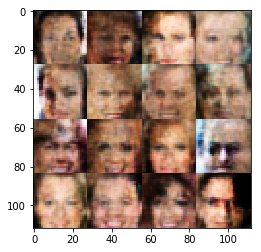

Epoch 1/3 Batch 4205 Discriminator Loss: 1.4238 Generator Loss: 0.7507


In [ ]:
batch_size = 32 # 2^5
z_dim = 128 # 2^7
learning_rate = 2e-4
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.